# Comparisons of asset allocations

We are comparing asset allocations in a state-switching model with those of normally distributed returns and ex-post optimality, respectively

In [338]:
import numpy as np
import pandas as pd
from numba import jit
from scipy import optimize as opt
from matplotlib import pyplot as plt
import seaborn as sns
import pyfolio as pf
import empyrical as ep
import time

### Prices

In [339]:
prices = pd.read_csv(
            # '/home/william/Dropbox/Thesis/mthReturns.csv',
            'C:/Users/willi/Dropbox/Thesis/mthReturns.csv',
            index_col=0,
            header=0)
prices = prices.drop(['SPXT'], axis=1)
prices.index = pd.to_datetime(prices.index)
prices = prices.sort_index()
colNames = ['High Yield',
            'Investment Grade',
            'Commodities',
            'Russell 2000',
            'Russell 1000']
prices.columns = colNames

### Returns

In [340]:
returns = np.log(prices/prices.shift(1))
returns = returns.dropna()

### Risk free rate

In [341]:
rf_data = pd.read_csv(
            # '/home/william/Dropbox/Thesis/rf.csv',
            'C:/Users/willi/Dropbox/Thesis/rf.csv',
            index_col=0,
            header=0
        )
rf_data = rf_data / 100.0
rf_data.index = pd.to_datetime(rf_data.index)
rf_data = rf_data.sort_index()

### Excess returns

In [342]:
rf = np.array(rf_data.iloc[1:,0])
excess_returns = returns.sub(rf, axis = 0)

### Split the data set into samples

In [350]:
excess_returns_13 = excess_returns.iloc[:365,:]  # Allocations are based on excess returns
returns_14 = returns.iloc[365:,:].copy()  # Performance is measured by total return
returns_14['RF']=rf[-60:]

# HMM

### HMM - Parameter estimates

In [352]:
cols = {1, 2}
idx = colNames

# ==================================== #
# ===== 2013 OUT OF SAMPLE ESTIMATES = #
# ==================================== #
hmm_mu_out = np.array([
    [0.4630, 0.2958],
    [0.2202, 0.4071],
    [0.3380, 0.1409],
    [0.7841, -0.7157],
    [0.8274, 0.0759]
])

hmm_cov_out = np.array([
    [
        [1.99231, 1.36487, 0.37123, 2.99855, 2.61054],
        [1.36487, 2.16692, -0.06630, 1.05048, 1.60245],
        [0.37123, -0.06630, 12.01824, 2.76506, 1.90716],
        [2.99855, 1.05048, 2.76506, 17.08546, 11.06018],
        [2.61054, 1.60245, 1.90716, 11.06018, 10.21645]
    ],
    [
        [17.54800, 3.34101, 6.55589, 22.19526, 16.02338],
        [3.34101, 4.09198, 1.55628, -0.09049, 1.46926],
        [6.55589, 1.55628, 33.26028, 8.46432, 6.03756],
        [22.19526, -0.09049, 8.46432, 72.22134, 46.50698],
        [16.02338, 1.46926, 6.03756, 46.50698, 42.42729]
        
    ]
])

probs_out = np.array([
    [0.94, 0.19],
    [0.06, 0.81]
])

mu_df_out = pd.DataFrame(hmm_mu_out, columns = cols, index = idx)

hmm_covs_out = [pd.DataFrame(
    hmm_cov_out[i],
    index=colNames,
    columns=colNames
    )
    for i in range(hmm_cov_out.shape[0])
]

print 'State 1_out: pos. semi. def?: {}'.format(np.all(np.linalg.eigvals(hmm_cov_out[0])>0))
print 'State 1_out: symmetric?: {}'.format(np.allclose(hmm_cov_out[0],hmm_cov_out[0].T))

print 'State 2_out: pos. semi. def?: {}'.format(np.all(np.linalg.eigvals(hmm_cov_out[1])>0))
print 'State 2_out: symmetric?: {}'.format(np.allclose(hmm_cov_out[1],hmm_cov_out[1].T))

# ==================================== #
# ===== 2013 IN SAMPLE ESTIMATES ===== #
# ==================================== #

hmm_mu_in = np.array([
    [0.4688, 0.1432],
    [0.2543, 0.3492],
    [-0.0033, 0.1711],
    [0.5783, 0.2671],
    [0.7502, -0.1591]
])

hmm_cov_in = np.array([
    [
        [1.81257, 1.24255, 0.45237, 2.63926, 2.30530],
        [1.24255, 2.04540, -0.31163, 0.72401, 1.29677],
        [0.45237, -0.31163, 11.26467, 2.37891, 1.60384],
        [2.63926, 0.72401, 2.37891, 16.26595, 10.10013],
        [2.30530, 1.29577, 1.60384, 10.10013, 9.15257]
    ],
    [
        [13.69091, 2.76775, 4.41894, 18.21422, 12.76019],
        [2.76775, 3.33186, 1.78968, -0.21804, 0.63192],
        [4.41894, 1.78968, 30.69232, 6.10187, 3.72403],
        [18.21422, -0.21804, 6.10187, 71.31116, 47.10775],
        [12.76019, 0.63192, 3.72403, 47.10775, 40.73222]
    ]
])

probs_in = np.array([
    [0.94, 0.16],
    [0.06, 0.84]
])

mu_df_in = pd.DataFrame(
    hmm_mu_in,
    columns=cols,
    index=idx
)

hmm_covs_in = [pd.DataFrame(
    hmm_cov_in[i],
    index=colNames,
    columns=colNames
    )
    for i in range(hmm_cov_in.shape[0])
]

print 'State 1_in: pos. semi. def?: {}'.format(np.all(np.linalg.eigvals(hmm_cov_in[0])>0))
print 'State 1_in: symmetric?: {}'.format(np.allclose(hmm_cov_in[0],hmm_cov_in[0].T))

print 'State 2_in: pos. semi. def?: {}'.format(np.all(np.linalg.eigvals(hmm_cov_in[1])>0))
print 'State 2_in: symmetric?: {}'.format(np.allclose(hmm_cov_in[1],hmm_cov_in[1].T))



# Indices - independent of in/out of sample
mask = np.ones_like(hmm_cov_out[0])
mask[np.triu_indices_from(mask)] = False  # False error call

State 1_out: pos. semi. def?: True
State 1_out: symmetric?: True
State 2_out: pos. semi. def?: True
State 2_out: symmetric?: True
State 1_in: pos. semi. def?: True
State 1_in: symmetric?: False
State 2_in: pos. semi. def?: True
State 2_in: symmetric?: True


### HMM - State simulation

In [353]:
from numba import jit

@jit(nopython=True)
def stateSim(S, M, start, probs, T, u, seed=12345):
    np.random.seed(seed)
    statePaths = np.ones((M, T)) * start
    state = np.ones(S)
    stateFreq = np.ones((M, S))
    for m in range(M):
        for t in range(T-1):
            # i defines state we are arriving from
            i = int(statePaths[m, t] - 1)
            for s in range(S):
                # Identifies which state we transition to
                state[s] = (np.sum(probs[:s, i]) < u[m, t] <= np.sum(probs[:s+1, i]))*(s+1)
            statePaths[m, t+1] = np.sum(state)
        for s in range(S):
            stateFreq[m, s] = np.sum(statePaths[m] == s + 1)
    return statePaths, stateFreq

In [354]:
S, M, start1, start2, T = 2, 50000, 1, 2, 60
u = np.random.random((M,T))

sp1_out, sf1_out = stateSim(S, M, start1, probs_out, T, u)
sp2_out, sf2_out = stateSim(S, M, start2, probs_out, T, u)

sp1_in, sf1_in = stateSim(S, M, start1, probs_in, T, u)
sp2_in, sf2_in = stateSim(S, M, start2, probs_in, T, u)

### HMM - Return simulation

In [355]:
@jit
def returnSim(S, M, N, A, start, mu, cov, probs, T, u, seed=12345):
    np.random.seed(seed)
    states, freq = stateSim(S, M, start, probs, T, u)
    returns = np.zeros((M*N, A, T))
    for m in range(M):
        for n in range(N):
            for s in range(S):
                returns[m*N + n, :, states[m] == s + 1] = \
                    np.random.multivariate_normal(
                        mu[:, s], cov[s], int(freq[m, s])
                    )
    return returns, states

In [356]:
A, N = len(colNames), 1

# ========================= #
# ===== Out of sample ===== #
# ========================= #

t0 = time.time()
ret1_out, s1_out = returnSim(S, M, N, A, start1, hmm_mu_out, hmm_cov_out, probs_out, T, u)
t1 = time.time()
print 'First returns computed in {}'.format(np.round(t1-t0, 4)), 'seconds.'

t0 = time.time()
ret2_out, s2_out = returnSim(S, M, N, A, start2, hmm_mu_out, hmm_cov_out, probs_out, T, u)
t1 = time.time()
print 'Second returns computed in {}'.format(np.round(t1-t0, 4)), 'seconds.'

# ===================== #
# ===== In sample ===== #
# ===================== #

t0 = time.time()
ret1_in, s1_in = returnSim(S, M, N, A, start1, hmm_mu_in, hmm_cov_in, probs_in, T, u)
t1 = time.time()
print 'First returns computed in {}'.format(np.round(t1-t0, 4)), 'seconds.'

t0 = time.time()
ret2_in, s2_in = returnSim(S, M, N, A, start2, hmm_mu_in, hmm_cov_in, probs_in, T, u)
t1 = time.time()
print 'Second returns computed in {}'.format(np.round(t1-t0, 4)), 'seconds.'

# ====================== #
# ===== Adjustment ===== #
# ====================== #

ret1_out /= 100
ret2_out /= 100

ret1_in /= 100
ret2_in /= 100

First returns computed in 30.74 seconds.
Second returns computed in 28.473 seconds.
First returns computed in 27.659 seconds.
Second returns computed in 28.109 seconds.


### Constrained optimiser

In [357]:
def check_sum(weights):
    return np.sum(weights) - 1.0

def boundedOptimiser(f, w, args, ApB, method='SLSQP'):
    bnds = tuple(zip(np.zeros(ApB), np.ones(ApB)))
    cons = ({'type': 'eq', 'fun': check_sum})
    res = opt.minimize(
        f, w, args=args, bounds=bnds, constraints=cons, method=method
    )
    return res

@jit(nopython=True)
def expectedUtilityMult(w, returns, rf, g, A, T):
    rfCR = np.exp(T * rf)  # rfCR: risk free compounded return
    denominator = 1 - g
    rCR = np.exp(np.sum(returns, axis=2))*rfCR  # rCR:  risky compounded return
    numerator = (w[A] * rfCR + np.sum(w[:A] * rCR, axis=1)) ** (1 - g)
    return -np.mean(numerator / denominator) * 100000

### HMM allocations

In [359]:
maturities = [3, 6, 9, 10, 12, 24, 36, 48, 60]
start_states = [1, 2]
gamma = [3,5,7,9]

# Labelling for data frames
labels = np.hstack((colNames, 'Risk Free'))
abbrev = ['HY', 'IG', 'C', 'R2', 'R1', 'RF']

# Assets to allocate weights to
a = len(labels)  # 6

# 6 standardised random weights on the unit interval
w = np.random.random(a)
w /= np.sum(w)

# Non-simulated risk free rate of return in percent
rf = 0.003

# A matrix of weights for each asset for each maturity (3 x 6)
hmm_weights_out = np.squeeze(list(zip(
    [np.repeat(w[i], len(maturities)) for i in range(len(w))]
))).T

hmm_weights_in = hmm_weights_out.copy()

# Technicality: dictionary that can contain solutions (weights) for all states and gammas
hmm_ws_out = {s: 
      {g: pd.DataFrame(
          hmm_weights_out.copy(),
          index=maturities,
          columns=abbrev
      )
       for g in gamma}
      for s in start_states}

hmm_ws_in = {s: 
      {g: pd.DataFrame(
          hmm_weights_in.copy(),
          index=maturities,
          columns=abbrev
      )
       for g in gamma}
      for s in start_states}

# Technicality: Lists that contains returns of maturities 3, 6 and 12 months
R1_out = [ret1_out[:, :, :mat] for mat in maturities]
R2_out = [ret2_out[:, :, :mat] for mat in maturities]
R_out = {0: R1_out, 1: R2_out}

R1_in = [ret1_in[:, :, :mat] for mat in maturities]
R2_in = [ret2_in[:, :, :mat] for mat in maturities]
R_in = {0: R1_in, 1: R2_in}

# Looping; j=[0,1], s=[1,2], gamma=[3,5,7,9], i=[0,1,2], mat=[3,6,9]
for j, s in enumerate(start_states):
    print 'start: {}'.format(s)
    for g in gamma:
        print 'gamma: {}'.format(g)
        for i, mat in enumerate(maturities):
            print 'maturity is: {}'.format(mat)
            args = R_out[j][i], rf, g, a-1, mat
            results = boundedOptimiser(expectedUtilityMult, w, args, a)
            hmm_ws_out[s][g].iloc[i,:] = np.round(results.x, 4)
            args = R_in[j][i], rf, g, a-1, mat
            results = boundedOptimiser(expectedUtilityMult, w, args, a)
            hmm_ws_in[s][g].iloc[i,:] = np.round(results.x, 4)

start: 1
gamma: 3
maturity is: 3
maturity is: 6
maturity is: 9
maturity is: 10
maturity is: 12
maturity is: 24
maturity is: 36
maturity is: 48
maturity is: 60
gamma: 5
maturity is: 3
maturity is: 6
maturity is: 9
maturity is: 10
maturity is: 12
maturity is: 24
maturity is: 36
maturity is: 48
maturity is: 60
gamma: 7
maturity is: 3
maturity is: 6
maturity is: 9
maturity is: 10
maturity is: 12
maturity is: 24
maturity is: 36
maturity is: 48
maturity is: 60
gamma: 9
maturity is: 3
maturity is: 6
maturity is: 9
maturity is: 10
maturity is: 12
maturity is: 24
maturity is: 36
maturity is: 48
maturity is: 60
start: 2
gamma: 3
maturity is: 3
maturity is: 6
maturity is: 9
maturity is: 10
maturity is: 12
maturity is: 24
maturity is: 36
maturity is: 48
maturity is: 60
gamma: 5
maturity is: 3
maturity is: 6
maturity is: 9
maturity is: 10
maturity is: 12
maturity is: 24
maturity is: 36
maturity is: 48
maturity is: 60
gamma: 7
maturity is: 3
maturity is: 6
maturity is: 9
maturity is: 10
maturity is:

### Allocation plots

In [360]:
aw_list = ['aw1','aw2']  # aw: asset weights
hmm_weights_out = {
    'aw1': {},
    'aw2': {}
}

hmm_weights_in = {
    'aw1': {},
    'aw2': {}
}

for j, aw in enumerate(aw_list):
    for i, a in enumerate(abbrev):
        hmm_weights_out[aw][a] = pd.DataFrame(
            (hmm_ws_out[j+1][g].iloc[:,i] for g in gamma),
            index=gamma,
            columns=maturities
        ).T
        hmm_weights_in[aw][a] = pd.DataFrame(
            (hmm_ws[j+1][g].iloc[:,i] for g in gamma),
            index=gamma,
            columns=maturities
        ).T

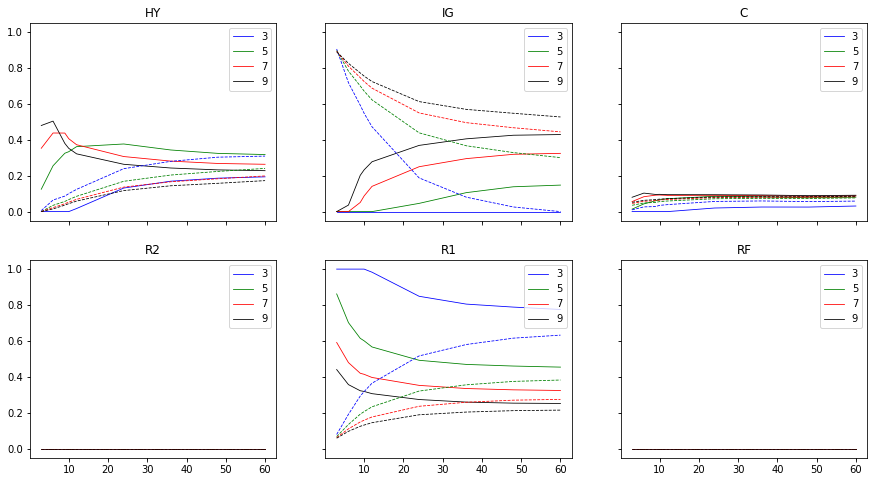

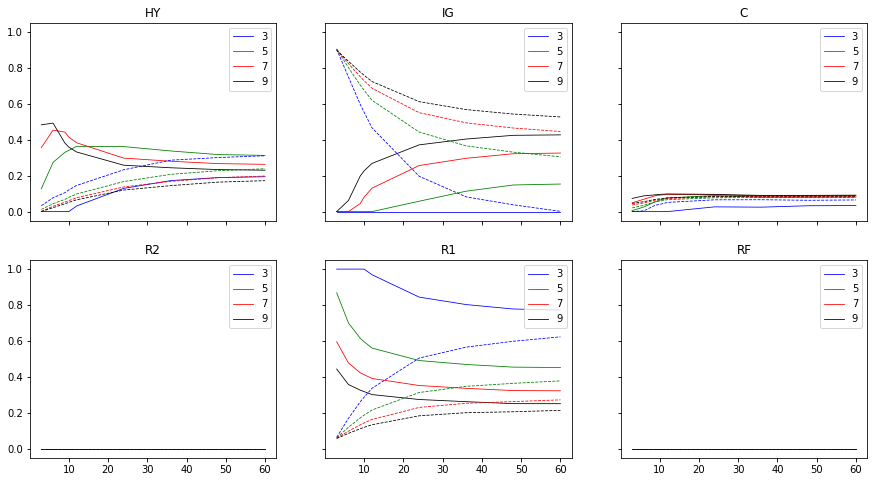

In [361]:
colors = np.array(['blue', 'green', 'red', 'black'])

# ========================= #
# ===== Out of sample ===== #
# ========================= #

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(15, 8)
)
for ax, a in zip(axes.flat, abbrev):
    ax.set_title(a)
    hmm_weights_out['aw1'][a].plot(
        legend=True,
        ax=ax,
        color=colors,
        linewidth=0.8
    )
    hmm_weights_out['aw2'][a].plot(
        legend=False,
        ax=ax,
        color=colors,
        linewidth=0.8,
        linestyle='dashed'
    )
plt.show()

# ===================== #
# ===== In sample ===== #
# ===================== #

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(15, 8)
)
for ax, a in zip(axes.flat, abbrev):
    ax.set_title(a)
    hmm_weights_in['aw1'][a].plot(
        legend=True,
        ax=ax,
        color=colors,
        linewidth=0.8
    )
    hmm_weights_in['aw2'][a].plot(
        legend=False,
        ax=ax,
        color=colors,
        linewidth=0.8,
        linestyle='dashed'
    )
plt.show()

# Normal model

### Norm - estimates

In [362]:
# ========================= #
# ===== Out of sample ===== #
# ========================= #

norm_mu_out = excess_returns_13.mean()
norm_cov_out = excess_returns_13.cov()

# ===================== #
# ===== In sample ===== #
# ===================== #

# parameter estimates on entire series
norm_mu_in = excess_returns.mean()
norm_cov_in = excess_returns.cov()

### Norm - returns simulation

In [363]:
np.random.seed(12345)
mn_out = np.random.multivariate_normal(
    norm_mu_out,
    norm_cov_out,
    size = (M, T))  # Multivariate normal
norm_rets_out = np.array([mn_out[i,:,:].T for i in range(M)])  # Streamline shape with hmm model returns

mn_in = np.random.multivariate_normal(
    norm_mu_in,
    norm_cov_in,
    size = (M, T))  # Multivariate normal
norm_rets_in = np.array([mn_in[i,:,:].T for i in range(M)])  # Streamline shape with hmm model returns

### Norm - allocations

In [366]:
# Assets to allocate weights to
a = len(labels)  # 6

# 6 standardised random weights on the unit interval
w = np.random.random(a)
w /= np.sum(w)

# Non-simulated risk free rate of return in percent
rf = 0.003

# A matrix of weights for each asset for each maturity (3 x 9)
norm_weights_out = np.squeeze(list(zip(
    [np.repeat(w[i], len(maturities)) for i in range(len(w))]
))).T

norm_weights_in = norm_weights_out.copy()

# Technicality: dictionary that can contain solutions for all gammas
norm_ws_out = {
    g: pd.DataFrame(
        norm_weights_out.copy(),
        index=maturities,
        columns=abbrev
    ) for g in gamma
}

norm_ws_in = {
    g: pd.DataFrame(
        norm_weights_in.copy(),
        index=maturities,
        columns=abbrev
    ) for g in gamma
}

# Technicality: Lists that contains returns of maturities 3, 6 
R_out = [norm_rets_out[:, :, :mat] for mat in maturities]
R_in = [norm_rets_in[:, :, :mat] for mat in maturities]

# Looping; j=[0,1], s=[1,2], gamma=[3,5,7,9], i=[0,1,2], mat=[3,6,9]
for g in gamma:
    print '\n gamma: {}'.format(g)
    for i, mat in enumerate(maturities):
        
        print 'Maturity is {}'.format(mat)
        
        # Out of sample
        args = R_out[i], rf, g, a-1, mat
        results = boundedOptimiser(expectedUtilityMult, w, args, a)
        norm_ws_out[g].iloc[i,:] = np.round(results.x, 4)
        
        # In sample
        args = R_in[i], rf, g, a-1, mat
        results = boundedOptimiser(expectedUtilityMult, w, args, a)
        norm_ws_in[g].iloc[i,:] = np.round(results.x, 4)


 gamma: 3
Maturity is 3
Maturity is 3
Maturity is 6
Maturity is 6
Maturity is 9
Maturity is 9
Maturity is 10
Maturity is 10
Maturity is 12
Maturity is 12
Maturity is 24
Maturity is 24
Maturity is 36
Maturity is 36
Maturity is 48
Maturity is 48
Maturity is 60
Maturity is 60

 gamma: 5
Maturity is 3
Maturity is 3
Maturity is 6
Maturity is 6
Maturity is 9
Maturity is 9
Maturity is 10
Maturity is 10
Maturity is 12
Maturity is 12
Maturity is 24
Maturity is 24
Maturity is 36
Maturity is 36
Maturity is 48
Maturity is 48
Maturity is 60
Maturity is 60

 gamma: 7
Maturity is 3
Maturity is 3
Maturity is 6
Maturity is 6
Maturity is 9
Maturity is 9
Maturity is 10
Maturity is 10
Maturity is 12
Maturity is 12
Maturity is 24
Maturity is 24
Maturity is 36
Maturity is 36
Maturity is 48
Maturity is 48
Maturity is 60
Maturity is 60

 gamma: 9
Maturity is 3
Maturity is 3
Maturity is 6
Maturity is 6
Maturity is 9
Maturity is 9
Maturity is 10
Maturity is 10
Maturity is 12
Maturity is 12
Maturity is 24
Matur

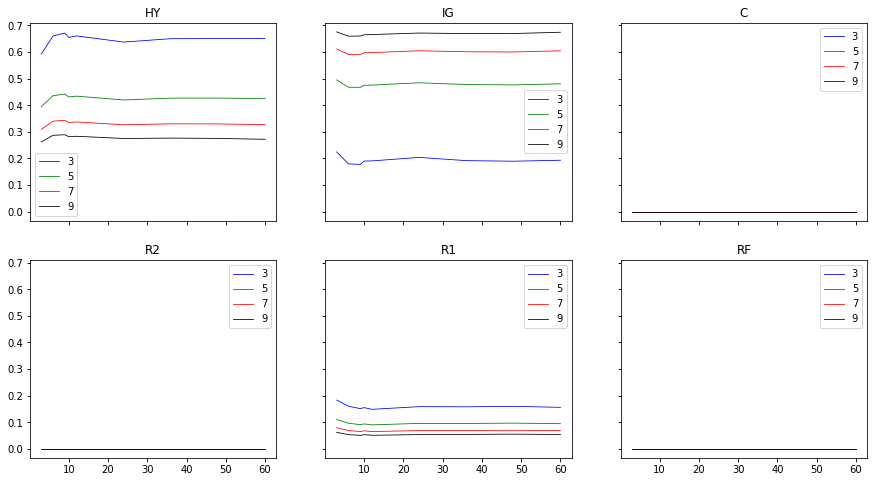

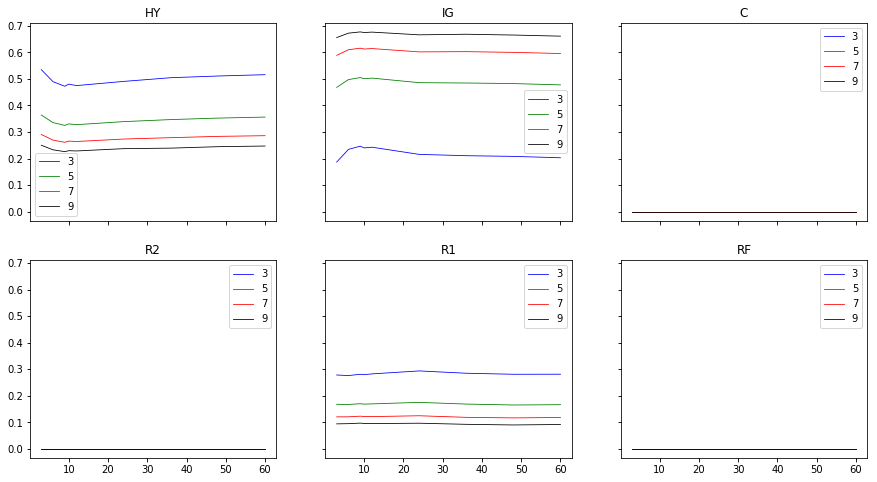

In [367]:
norm_weights_out = {}
norm_weights_in = {}

for i, a in enumerate(abbrev):
    norm_weights_out[a] = pd.DataFrame(
        (norm_ws_out[g].iloc[:,i] for g in gamma),
        index=gamma,
        columns=maturities
    ).T
    norm_weights_in[a] = pd.DataFrame(
        (norm_ws_in[g].iloc[:,i] for g in gamma),
        index=gamma,
        columns=maturities
    ).T

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(15, 8)
)
for ax, a in zip(axes.flat, abbrev):
    ax.set_title(a)
    norm_weights_out[a].plot(
        legend=True,
        ax=ax,
        color=colors,
        linewidth=0.8
    )
plt.show()

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    sharex=True,
    sharey=True,
    figsize=(15, 8)
)
for ax, a in zip(axes.flat, abbrev):
    ax.set_title(a)
    norm_weights_in[a].plot(
        legend=True,
        ax=ax,
        color=colors,
        linewidth=0.8
    )
plt.show()

# Out of sample test, return data

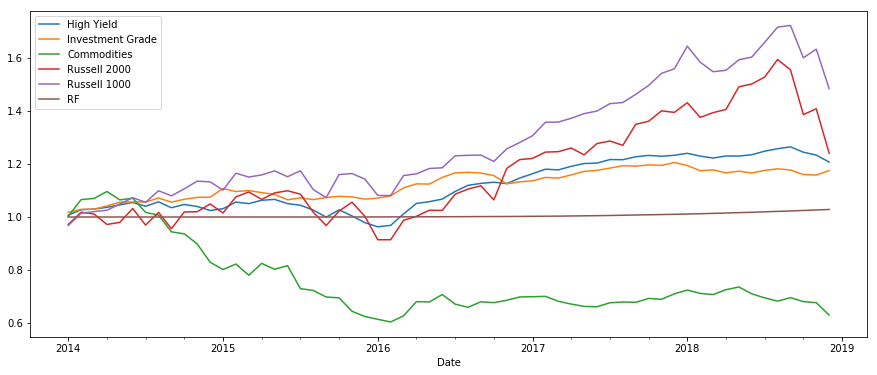

In [368]:
# Cumulative returns
CR = np.exp(returns_14).cumprod()
CR.plot(figsize=(15,6))

### HMM - performance

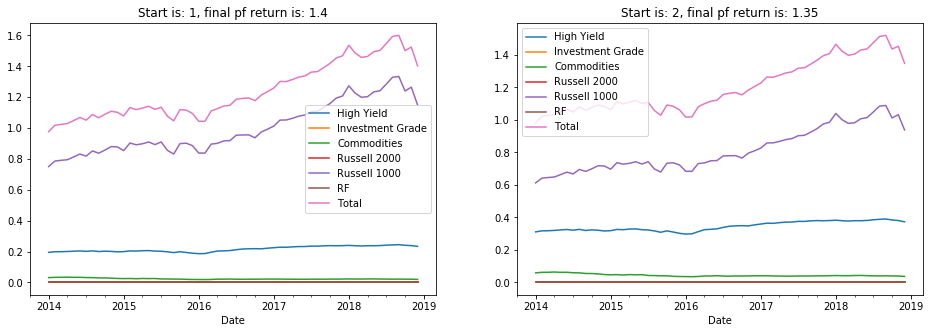

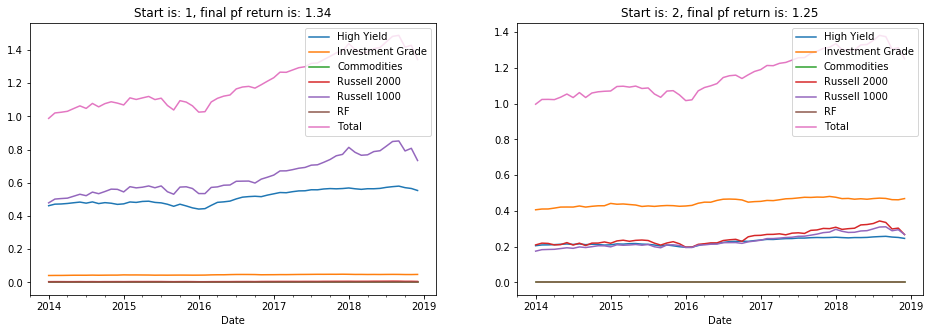

In [369]:
# Out of sample weights: start: 1, gamma: 3, maturity: 60
hmm_gamma = 3
lst = ['w1', 'w2']
hmm_wealth_out = {
    'w1': {},
    'w2': {}
}

hmm_wealth_in = {
    'w1': {},
    'w2': {}
}

fig, axes = plt.subplots(ncols=2, figsize=(16,5))
for s, wi in enumerate(lst):
    hmm_weights_out=np.array(hmm_ws_out[s+1][hmm_gamma].iloc[8,:]) # index 8 is month 60
    hmm_wealth_out[wi] = hmm_weights_out*CR
    hmm_wealth_out[wi].plot(ax=axes.flat[s])
    hmm_wealth_out[wi].sum(axis=1).plot(label='Total', ax=axes.flat[s])
    axes.flat[s].legend()
    axes.flat[s].set_title('Start is: {}, final pf return is: {}'.format(
        s+1,
        round(hmm_wealth_out[wi].sum(axis=1).iloc[59], 2)
    ))
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(16,5))
for s, wi in enumerate(lst):
    hmm_weights_in=np.array(hmm_ws_in[s+1][hmm_gamma].iloc[8,:]) # index 8 is month 60
    hmm_wealth_in[wi] = hmm_weights_in*CR
    hmm_wealth_in[wi].plot(ax=axes.flat[s])
    hmm_wealth_in[wi].sum(axis=1).plot(label='Total', ax=axes.flat[s])
    axes.flat[s].legend()
    axes.flat[s].set_title('Start is: {}, final pf return is: {}'.format(
        s+1,
        round(hmm_wealth_in[wi].sum(axis=1).iloc[59], 2)
    ))
plt.show()

### Norm - performance

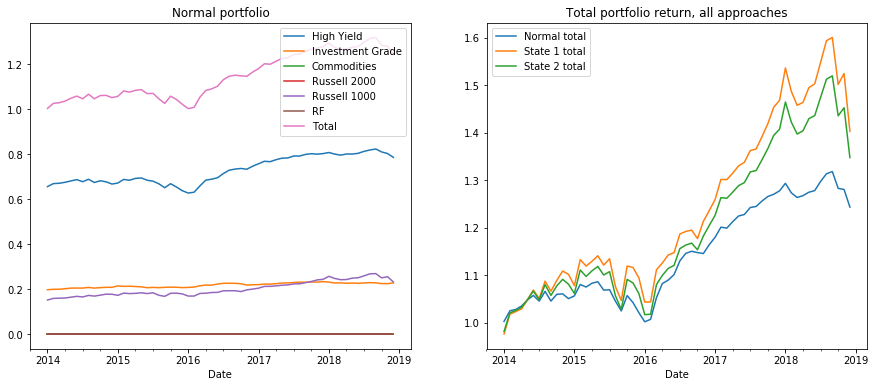

Date
2018-08-31    1.313817
2018-09-28    1.318577
2018-10-31    1.283106
2018-11-30    1.280844
2018-12-31    1.243753
dtype: float64

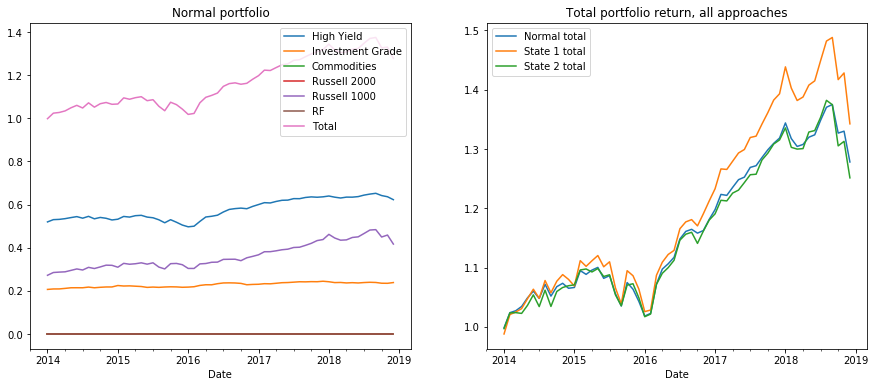

Date
2018-08-31    1.370317
2018-09-28    1.374907
2018-10-31    1.326757
2018-11-30    1.329989
2018-12-31    1.278022
dtype: float64

In [370]:
# Out of sample weights: start: 1, gamma: 3, maturity: 60
norm_gamma = 3
norm_wealth_out = {}
norm_wealth_in = {}

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
norm_weights_out=np.array(norm_ws_out[norm_gamma].iloc[8,:]) # index 8 is month 60
norm_wealth_out[norm_gamma] = norm_weights_out*CR
norm_wealth_out[norm_gamma].plot(ax=ax1)
norm_wealth_out[norm_gamma].sum(axis=1).plot(label='Total', ax=ax1)
ax1.legend()
ax1.set_title('Normal portfolio')
norm_wealth_out[norm_gamma].sum(axis=1).plot(label='Normal total', ax=ax2)
hmm_wealth_out['w1'].sum(axis=1).plot(label='State 1 total', ax=ax2)
hmm_wealth_out['w2'].sum(axis=1).plot(label='State 2 total', ax=ax2)
ax2.legend()
ax2.set_title('Total portfolio return, all approaches')
plt.show()
# wealth at end of period
display(norm_wealth_out[norm_gamma].sum(axis=1).tail())

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
norm_weights_in=np.array(norm_ws_in[norm_gamma].iloc[8,:]) # index 8 is month 60
norm_wealth_in[norm_gamma] = norm_weights_in*CR
norm_wealth_in[norm_gamma].plot(ax=ax1)
norm_wealth_in[norm_gamma].sum(axis=1).plot(label='Total', ax=ax1)
ax1.legend()
ax1.set_title('Normal portfolio')
norm_wealth_in[norm_gamma].sum(axis=1).plot(label='Normal total', ax=ax2)
hmm_wealth_in['w1'].sum(axis=1).plot(label='State 1 total', ax=ax2)
hmm_wealth_in['w2'].sum(axis=1).plot(label='State 2 total', ax=ax2)
ax2.legend()
ax2.set_title('Total portfolio return, all approaches')
plt.show()
# wealth at end of period
display(norm_wealth_in[norm_gamma].sum(axis=1).tail())

### Risk metrics

OUT OF SAMPLE 

Start is: 1
Max drawdown: -12.44 pct.


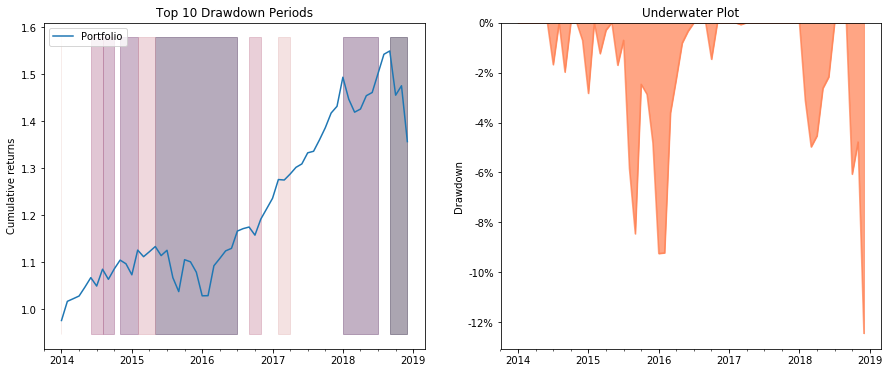

Start is: 2
Max drawdown: -11.17 pct.


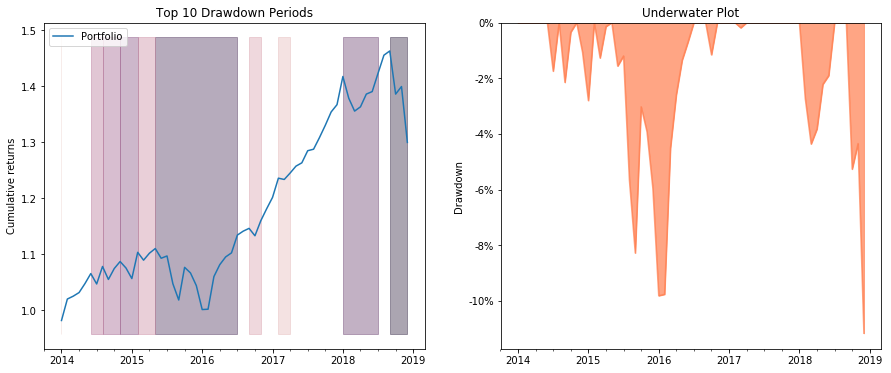

Max drawdown: -7.97 pct.


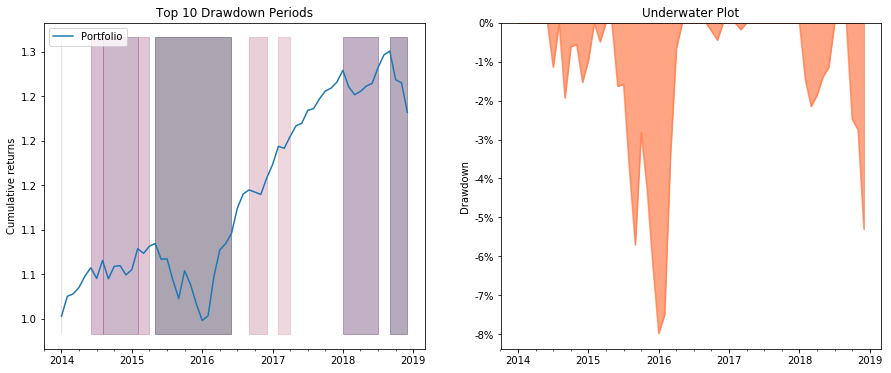

IN SAMPLE 

Start is: 1
Max drawdown: -9.41 pct.


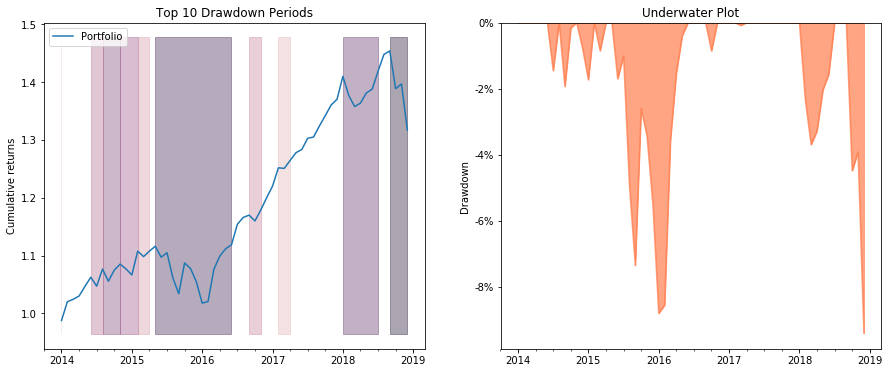

Start is: 2
Max drawdown: -8.87 pct.


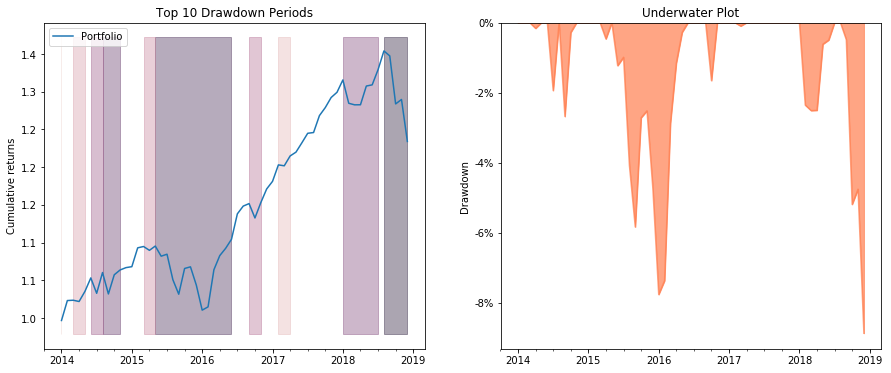

Max drawdown: -7.7 pct.


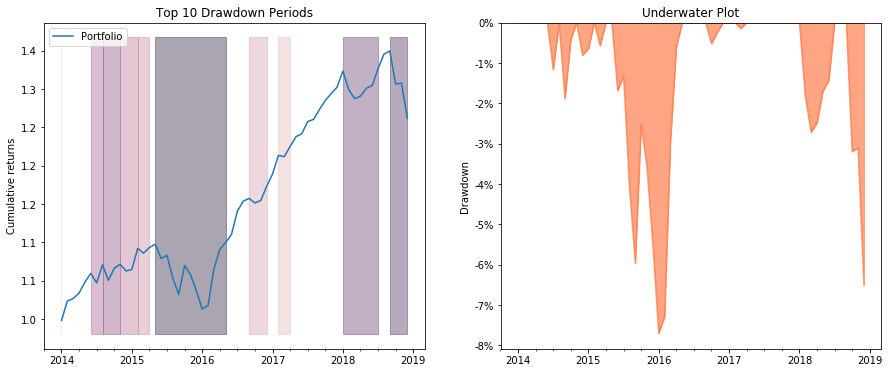

In [371]:
# Out of sample weights: start: 1, gamma: 3, maturity: 60
hmm_gamma = 3
lst = ['w1', 'w2']
hmm_returns_out = {
    'w1': {},
    'w2': {}
}

hmm_returns_in = {
    'w1': {},
    'w2': {}
}

print 'OUT OF SAMPLE \n'
for s, wi in enumerate(lst):
    print 'Start is: {}'.format(s+1)
    hmm_weights_out=np.array(hmm_ws_out[s+1][hmm_gamma].iloc[8,:]) # index 8 is month 60
    
    hmm_returns_out[wi] = hmm_weights_out*returns_14
    hmm_pf_returns_out = hmm_returns_out[wi].sum(axis=1)
    hmm_md_out = round(ep.max_drawdown(hmm_pf_returns_out)*100, 2)
    
    print 'Max drawdown: {} pct.'.format(hmm_md_out)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
    pf.plot_drawdown_periods(hmm_pf_returns_out, ax=ax1)
    pf.plot_drawdown_underwater(hmm_pf_returns_out, ax=ax2)
    plt.show()

# Out of sample weights: start: 1, gamma: 3, maturity: 60

norm_weights_out=np.array(norm_ws_out[ante_gamma].iloc[8,:]) # index 8 is month 60
norm_returns_out = norm_weights_out*returns_14
norm_pf_returns_out = norm_returns_out.sum(axis=1)
norm_md_out = round(ep.max_drawdown(norm_pf_returns_out)*100, 2)

print 'Max drawdown: {} pct.'.format(norm_md_out)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
pf.plot_drawdown_periods(norm_pf_returns_out, ax=ax1)
pf.plot_drawdown_underwater(norm_pf_returns_out, ax=ax2)
plt.show()

print 'IN SAMPLE \n'
for s, wi in enumerate(lst):
    print 'Start is: {}'.format(s+1)
    hmm_weights_in=np.array(hmm_ws_in[s+1][hmm_gamma].iloc[8,:]) # index 8 is month 60
    
    hmm_returns_in[wi] = hmm_weights_in*returns_14
    hmm_pf_returns_in = hmm_returns_in[wi].sum(axis=1)
    hmm_md_in = round(ep.max_drawdown(hmm_pf_returns_in)*100, 2)
    
    print 'Max drawdown: {} pct.'.format(hmm_md_in)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
    pf.plot_drawdown_periods(hmm_pf_returns_in, ax=ax1)
    pf.plot_drawdown_underwater(hmm_pf_returns_in, ax=ax2)
    plt.show()

# Out of sample weights: start: 1, gamma: 3, maturity: 60

norm_weights_in=np.array(norm_ws_in[ante_gamma].iloc[8,:]) # index 8 is month 60
norm_returns_in = norm_weights_in*returns_14
norm_pf_returns_in = norm_returns_in.sum(axis=1)
norm_md_in = round(ep.max_drawdown(norm_pf_returns_in)*100, 2)

print 'Max drawdown: {} pct.'.format(norm_md_in)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
pf.plot_drawdown_periods(norm_pf_returns_in, ax=ax1)
pf.plot_drawdown_underwater(norm_pf_returns_in, ax=ax2)
plt.show()

### Updating the utility function

In [372]:
# @jit(nopython=True)
def expectedUtilityMult2(w, returns, g):
    # CR: compounded return
    CR = np.exp(np.sum(returns, axis=0))
    
    numerator = np.sum(w * CR) ** (1 - g)
    denonimator = 1 - g
    return -numerator / denonimator * 100000

# Test to see if we achieve the "correct" utility
for i in range(2):
    print 'Utility for state {} is {}'.format(
        i + 1,
        -round(expectedUtilityMult2(
            np.array(hmm_ws_out[i+1][hmm_gamma].iloc[8,:]),
            returns_14,
            hmm_gamma
        )/100000,4)
    )

for i in range(2):
    print 'Utility for state {} is {}'.format(
        i + 1,
        -round(expectedUtilityMult2(
            np.array(hmm_ws_in[i+1][hmm_gamma].iloc[8,:]),
            returns_14,
            hmm_gamma
        )/100000,4)
    )

Utility for state 1 is -0.2539
Utility for state 2 is -0.2752
Utility for state 1 is -0.2775
Utility for state 2 is -0.3194


# Ex post optimal weights

In [373]:
# [A]ssets [p]lus [B]ank account
ApB = 6

# Standardised weights on the unit interval
w = np.random.random(ApB)
w /= np.sum(w)

# Arguments other than w to be passed to expectedUtilityMult
args = returns_14, hmm_gamma

# Function over which to optimise
f = expectedUtilityMult2

# Results
oos_result = boundedOptimiser(f, w, args, ApB, method='SLSQP')
opt_weights = oos_result.x

,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Final Return,1.34,1.4,1.25,1.35,1.28,1.24,1.48


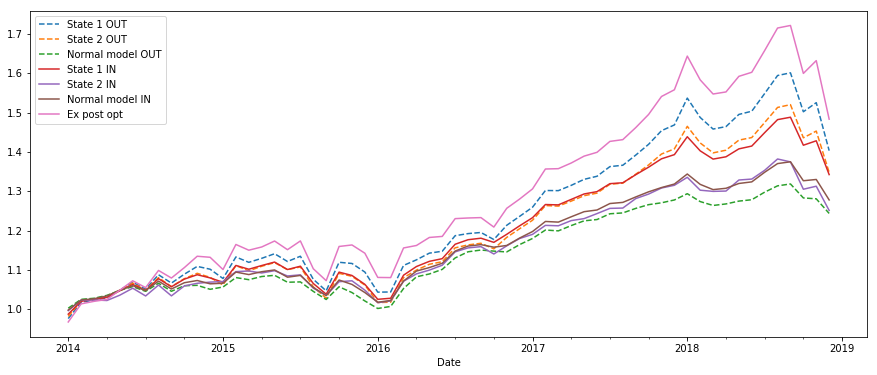

,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Max Drawdown,-9.41,-12.44,-8.87,-11.17,-7.7,-7.97,-14.5



 OUT OF SAMPLE 



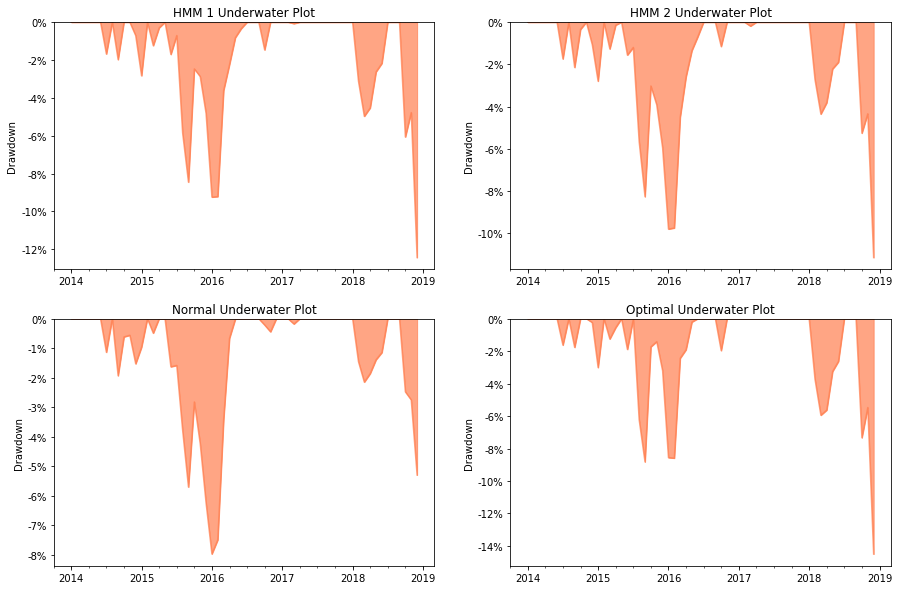


 IN SAMPLE 



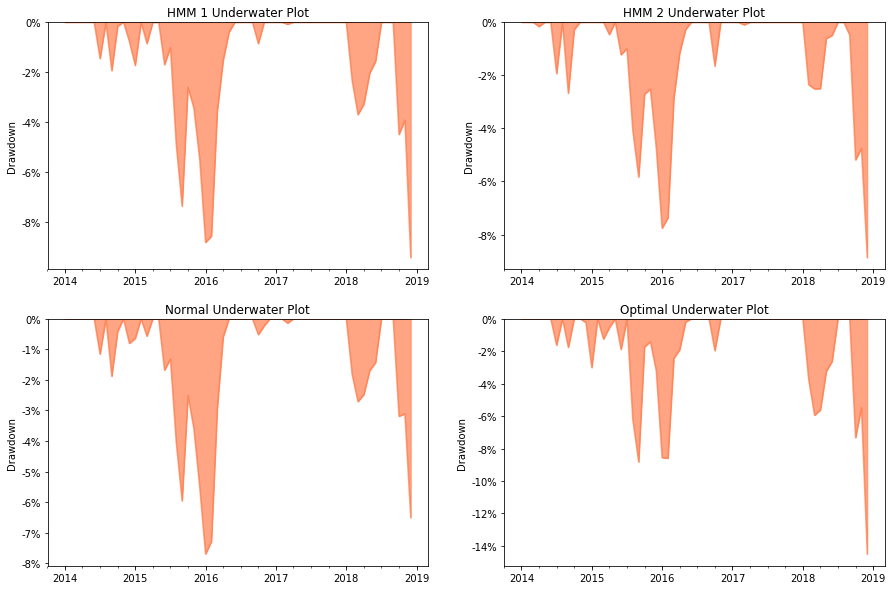

In [380]:
# plotting return series
data = {
    'HMM 1 OUT': round(hmm_wealth_out['w1'].sum(axis=1).iloc[59],2),
    'HMM 2 OUT': round(hmm_wealth_out['w2'].sum(axis=1).iloc[59],2),
    'NORM OUT': round(norm_wealth_out[norm_gamma].sum(axis=1).iloc[59],2),
    'HMM 1 IN': round(hmm_wealth_in['w1'].sum(axis=1).iloc[59],2),
    'HMM 2 IN': round(hmm_wealth_in['w2'].sum(axis=1).iloc[59],2),
    'NORM IN': round(norm_wealth_in[norm_gamma].sum(axis=1).iloc[59],2),
    'OPT': round(opt_wealth.sum(axis=1).iloc[59],2)
}
display(pd.DataFrame(
    data,
    index=['Final Return']
))
# print 'Final return, HMM 1 OUT: {}'.format(round(hmm_wealth_out['w1'].sum(axis=1).iloc[59],2))
# print 'Final return, HMM 2 OUT: {}'.format(round(hmm_wealth_out['w2'].sum(axis=1).iloc[59],2))
# print 'Final return, Norm OUT: {}'.format(round(norm_wealth_out[norm_gamma].sum(axis=1).iloc[59],2))
# print 'Final return, HMM 1 IN: {}'.format(round(hmm_wealth_in['w1'].sum(axis=1).iloc[59],2))
# print 'Final return, HMM 2 IN: {}'.format(round(hmm_wealth_in['w2'].sum(axis=1).iloc[59],2))
# print 'Final return, Norm IN: {}'.format(round(norm_wealth_in[norm_gamma].sum(axis=1).iloc[59],2))
# print 'Final return, Opt: {}'.format(round(opt_wealth.sum(axis=1).iloc[59],2))

fig = plt.figure(figsize=(15,6))
hmm_wealth_out['w1'].sum(axis=1).plot(label='State 1 OUT', linestyle='dashed')
hmm_wealth_out['w2'].sum(axis=1).plot(label='State 2 OUT', linestyle='dashed')
norm_wealth_out[norm_gamma].sum(axis=1).plot(label='Normal model OUT', linestyle='dashed')

hmm_wealth_in['w1'].sum(axis=1).plot(label='State 1 IN')
hmm_wealth_in['w2'].sum(axis=1).plot(label='State 2 IN')
norm_wealth_in[norm_gamma].sum(axis=1).plot(label='Normal model IN')

opt_wealth.sum(axis=1).plot(label='Ex post opt')

plt.legend()
plt.show()

# HMM underwater
hmm_pf_returns_1_out = hmm_returns_out['w1'].sum(axis=1)
hmm_pf_returns_2_out = hmm_returns_out['w2'].sum(axis=1)

hmm_pf_returns_1_in = hmm_returns_in['w1'].sum(axis=1)
hmm_pf_returns_2_in = hmm_returns_in['w2'].sum(axis=1)

# Norm underwater
# norm_pf_returns

# Optimal underwater allocation
opt_wealth = opt_weights*CR
opt_returns = opt_weights*returns_14
opt_pf_returns = opt_returns.sum(axis=1)

# For printing
hmm_md_1_out = round(ep.max_drawdown(hmm_pf_returns_1_out)*100, 2)
hmm_md_2_out = round(ep.max_drawdown(hmm_pf_returns_2_out)*100, 2)
norm_md_out = round(ep.max_drawdown(norm_pf_returns_out)*100, 2)

hmm_md_1_in = round(ep.max_drawdown(hmm_pf_returns_1_in)*100, 2)
hmm_md_2_in = round(ep.max_drawdown(hmm_pf_returns_2_in)*100, 2)
norm_md_in = round(ep.max_drawdown(norm_pf_returns_in)*100, 2)

opt_md = round(ep.max_drawdown(opt_pf_returns)*100, 2)

data = {
    'HMM 1 OUT': hmm_md_1_out,
    'HMM 2 OUT': hmm_md_2_out,
    'NORM OUT': norm_md_out,
    'HMM 1 IN': hmm_md_1_in,
    'HMM 2 IN': hmm_md_2_in,
    'NORM IN': norm_md_in,
    'OPT': opt_md
}

display(pd.DataFrame(
    data,
    index=['Max Drawdown']
))

# print 'Max drawdown, HMM1: {} pct.'.format(hmm_md_1)
# print 'Max drawdown, HMM2: {} pct.'.format(hmm_md_2)
# print 'Max drawdown, NORM: {} pct.'.format(norm_md)
# print 'Max drawdown, OPT: {} pct.'.format(opt_md)

print '\n OUT OF SAMPLE \n'
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
pf.plot_drawdown_underwater(hmm_pf_returns_1_out, ax=axes.flat[0])
axes.flat[0].set_title('HMM 1 Underwater Plot')
pf.plot_drawdown_underwater(hmm_pf_returns_2_out, ax=axes.flat[1])
axes.flat[1].set_title('HMM 2 Underwater Plot')
pf.plot_drawdown_underwater(norm_pf_returns_out, ax=axes.flat[2])
axes.flat[2].set_title('Normal Underwater Plot')
pf.plot_drawdown_underwater(opt_pf_returns, ax=axes.flat[3])
axes.flat[3].set_title('Optimal Underwater Plot')
plt.show()

print '\n IN SAMPLE \n'
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15,10))
pf.plot_drawdown_underwater(hmm_pf_returns_1_in, ax=axes.flat[0])
axes.flat[0].set_title('HMM 1 Underwater Plot')
pf.plot_drawdown_underwater(hmm_pf_returns_2_in, ax=axes.flat[1])
axes.flat[1].set_title('HMM 2 Underwater Plot')
pf.plot_drawdown_underwater(norm_pf_returns_in, ax=axes.flat[2])
axes.flat[2].set_title('Normal Underwater Plot')
pf.plot_drawdown_underwater(opt_pf_returns, ax=axes.flat[3])
axes.flat[3].set_title('Optimal Underwater Plot')
plt.show()

## Sharpe Ratio

The normal portfolio at $\gamma=3$ shows up with the best ex post Sharpe Ratio. We computed the Sharpe Ratio by considering the excess returns from January 2014 through December 2018, using the formula:

$$
SR = \frac{\mu - r^f}{\sigma},
$$

where $\mu$ is the average return, $rf$ is the risk-free rate and $\sigma$ the volatility of the asset / portfolio. Computing the portfolio Sharpe Ratio requires the portfolio weights:

$$
\mu_{pf} = \omega_{pf}' \mu\\
\sigma_{pf} = \left(\omega_{pf}' \Omega \omega_{pf}\right)^{1/2} \\
R^f = r^f\iota,
$$

where $\omega$ is a column vector of weights for each asset, $\mu$ is a column vector of means and $\Omega$ is a covariance matrix, and $\iota$ is a column vector of $1's$ inheriting the dimension of $\mu$.

High Yield          0.002666
Investment Grade    0.002221
Commodities        -0.008145
Russell 2000        0.003121
Russell 1000        0.006103
dtype: float64

,High Yield,Investment Grade,Commodities,Russell 2000,Russell 1000
High Yield,0.000218,0.000071,0.000292,0.000386,0.000317
Investment Grade,0.000071,0.000117,0.000015,0.000033,0.000051
Commodities,0.000292,0.000015,0.001241,0.000449,0.000355
Russell 2000,0.000386,0.000033,0.000449,0.002028,0.001217
Russell 1000,0.000317,0.000051,0.000355,0.001217,0.001023


High Yield          0.000218
Investment Grade    0.000117
Commodities         0.001241
Russell 2000        0.002028
Russell 1000        0.001023
dtype: float64

0.00610312339815
0.0319855046114
0.190809039041
[ 0.  0.  0.  0.  1.]
0.00610312339816
0.0319855046115
0.190809039041
High Yield          0.180666
Investment Grade    0.205087
Commodities        -0.231246
Russell 2000        0.069306
Russell 1000        0.190809
dtype: float64


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.004351,0.004995,0.003208,0.004208,0.003542,0.003116,0.006103
Std. devs,0.021285,0.027206,0.018245,0.024394,0.016010,0.014382,0.031986
Sharpe Ratios,0.200000,0.180000,0.180000,0.170000,0.220000,0.220000,0.190000


Text(0,0.5,'Excess return')

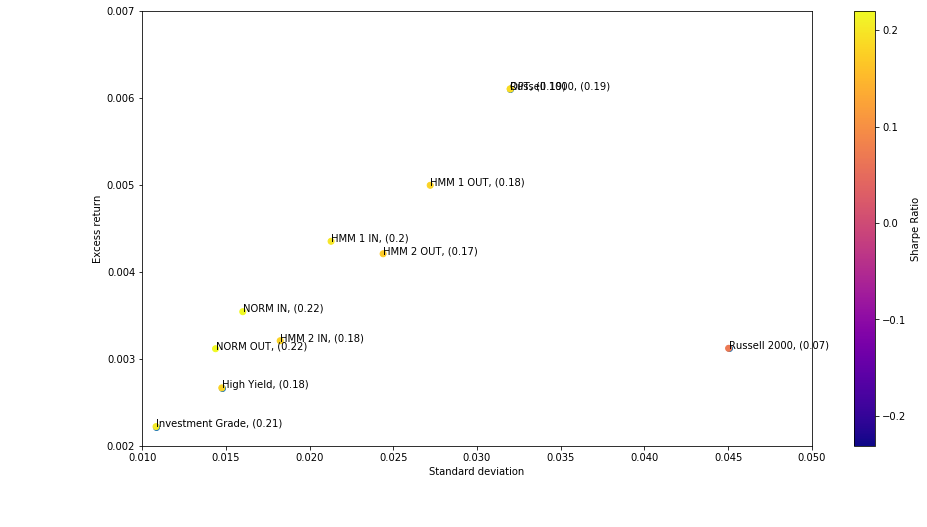

In [388]:
# 14-18 series
excess_returns_14 = excess_returns[365:]

# Historical excess moments
mu = excess_returns_14.mean()
std = excess_returns_14.std()
cov = excess_returns_14.cov()

# Asset performances --- For scatter plot
asset_returns = mu
asset_stds = std
asset_srs = asset_returns / asset_stds


# HMM performances
hmm_weights_1_out = np.array(hmm_ws_out[1][ante_gamma].iloc[8,:5])
hmm_1_pf_return_out = np.dot(hmm_weights_1_out, mu)
hmm_1_pf_std_out = np.sqrt(np.dot(hmm_weights_1_out, np.dot(cov, hmm_weights_1_out.T)))
hmm_1_pf_sr_out = round(hmm_1_pf_return_out / hmm_1_pf_std_out, 2)

hmm_weights_2_out = np.array(hmm_ws_out[2][ante_gamma].iloc[8,:5])
hmm_2_pf_return_out = np.dot(hmm_weights_2_out, mu)
hmm_2_pf_std_out = np.sqrt(np.dot(hmm_weights_2_out, np.dot(cov, hmm_weights_2_out.T)))
hmm_2_pf_sr_out = round(hmm_2_pf_return_out / hmm_2_pf_std_out, 2)

hmm_weights_1_in = np.array(hmm_ws_in[1][ante_gamma].iloc[8,:5])
hmm_1_pf_return_in = np.dot(hmm_weights_1_in, mu)
hmm_1_pf_std_in = np.sqrt(np.dot(hmm_weights_1_in, np.dot(cov, hmm_weights_1_in.T)))
hmm_1_pf_sr_in = round(hmm_1_pf_return_in / hmm_1_pf_std_in, 2)

hmm_weights_2_in = np.array(hmm_ws_in[2][ante_gamma].iloc[8,:5])
hmm_2_pf_return_in = np.dot(hmm_weights_2_in, mu)
hmm_2_pf_std_in = np.sqrt(np.dot(hmm_weights_2_in, np.dot(cov, hmm_weights_2_in.T)))
hmm_2_pf_sr_in = round(hmm_2_pf_return_in / hmm_2_pf_std_in, 2)

# Normal performances
norm_weights_out = np.array(norm_ws_out[ante_gamma].iloc[8,:5])
norm_pf_return_out = np.dot(norm_weights_out, mu)
norm_pf_std_out = np.sqrt(np.dot(norm_weights_out, np.dot(cov, norm_weights_out.T)))
norm_pf_sr_out = round(norm_pf_return_out / norm_pf_std_out, 2)

# Normal performances
norm_weights_in = np.array(norm_ws_in[ante_gamma].iloc[8,:5])
norm_pf_return_in = np.dot(norm_weights_in, mu)
norm_pf_std_in = np.sqrt(np.dot(norm_weights_in, np.dot(cov, norm_weights_in.T)))
norm_pf_sr_in = round(norm_pf_return_in / norm_pf_std_in, 2)

# Optimal performance
opt_weights = opt_weights[:5]
opt_pf_return = np.dot(opt_weights, mu)
opt_pf_std = np.sqrt(np.dot(opt_weights, np.dot(cov, opt_weights.T)))
opt_pf_sr = round(opt_pf_return / opt_pf_std, 2)

# Collection
all_rets = np.hstack((
    asset_returns,
    hmm_1_pf_return_out,
    hmm_2_pf_return_out,
    norm_pf_return_out,
    hmm_1_pf_return_in,
    hmm_2_pf_return_in,
    norm_pf_return_in,
    opt_pf_return
))
all_stds = np.hstack((
    asset_stds,
    hmm_1_pf_std_out,
    hmm_2_pf_std_out,
    norm_pf_std_out,
    hmm_1_pf_std_in,
    hmm_2_pf_std_in,
    norm_pf_std_in,
    opt_pf_std
))
all_srs = np.hstack((
    asset_srs,
    hmm_1_pf_sr_out,
    hmm_2_pf_sr_out,
    norm_pf_sr_out,
    hmm_1_pf_sr_in,
    hmm_2_pf_sr_in,
    norm_pf_sr_in,
    opt_pf_sr
))


txt = [
    'HMM 1 OUT',
    'HMM 2 OUT',
    'NORM OUT',
    'HMM 1 IN',
    'HMM 2 IN',
    'NORM IN',
    'OPT'
]

data = dict(zip(txt, zip(all_rets[-len(txt):], all_stds[-len(txt):], all_srs[-len(txt):])))

display(pd.DataFrame(
    data,
    index=['Returns','Std. devs','Sharpe Ratios']
))

# print 'hmm 1 SR is: {}'.format(hmm_1_pf_sr)
# print 'hmm 2 SR is: {}'.format(hmm_2_pf_sr)
# print 'Norm SR is: {}'.format(norm_pf_sr)
# print 'Opt SR is: {}'.format(opt_pf_sr)

annotes = np.hstack((labels[:5], txt))

# Dictionaries are not ordered due to memory efficiency. All parameters are thus paired through to zips.
an_dic = dict(
    zip(
        annotes,
        zip(
            np.round(all_srs, 2),
            all_stds,
            all_rets
        )
    )
)

fig = plt.figure(figsize=(15,8))
plt.scatter(asset_stds, asset_returns)
plt.scatter(all_stds, all_rets, c=all_srs, cmap='plasma')
plt.colorbar(label = 'Sharpe Ratio')
for (k, a) in an_dic.items():
    plt.annotate('{}, ({})'.format(k, a[0]), (a[1], a[2]))
plt.axis(xmin=0.01, xmax=0.05, ymin=0.002, ymax=0.007)
plt.xlabel('Standard deviation')
plt.ylabel('Excess return')

# When this will work (conda install and reboot)
# from adjustText import adjust_text
# texts = []
# for x, y, s in zip(eucs, covers, text):
#     texts.append(plt.text(all_stds, all_rets, annotes))
# adjust_text(texts, only_move='y', arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

### Sharpe ratio results

#### Primary results
The normal portfolio has the highest Sharpe ratio. The optimal portfolio comes in second and the Bull state hmm comes in third with the Bear state hmm falling into a close last place.

#### Hypothesis on normal performance
The allocations are made ex ante and thus any ex post outcome on Share Ratios can be due to noise. We could make the argument that, with the normal model lacking information, we are seeing an 'erring on caution' approach to allocation. The returns are considerably reduced, but relative to risk we are doing quite well. This argument falls short when we consider the optimal portfolio. Here we should then see a much poorer Sharpe Ratio. This makes us revert to the ex-ante / ex-post consideration. Ex post, the best we can do with respect to returns is a 100 pct. investment in Russell 1000 where the best returns are, which additionally happens to have a strong Sharpe Ratio.

In addition, we should vary $\gamma$ to see if the relationship lasts across all levels of risk aversion.

The above argument about caution has implications for the HMM models also. For the HMM models we are saying that the observed variances and means will not continue, but will depend on the length and strength of a regime. Thus, with more information to come by, we would dare to take a slightly larger risk, and are rewarded with a comfortable cushion to the normal portfolio in the performance of returns. Again, the optimal portfolio has even more information - it has all the information. We should then see a horrible Sharpe Ratio here. Once more, this could be due to the investment in Russell 1000 that not only performs best on returns but also really well on Sharpe Ratio.

#### Optimal portfolio
There is a collision between Russell 1000 and the optimal portfolio at the top centre of the plot. The collision is unavoidable, as the two allocations are identical - the optimal portfolio is completely invested in Russell 1000.

### First new results

The comparison above is the first time we are seeing all results gathered. This calls for a short analysis.

1. The diversified portfolios (HMM 1, HMM 2 and Normal model based allocations) are all hit fairly hard by the financial crisis.
2. The HMM models are heavier on December 2018-crash assets (R1, R2 and C) and thus experience large drawdowns that month.
3. The optimal portfolio has the same drawdown in the financial crises as the other portfolios, but dwards that drawdown by the December '18 drawdown.
4. The December '18 drawdown for the optimal portfolio is explained by pure concentration on R1.
5. The drawdowns are a poor predictor for returns - the portfolio with the lowest drawdown (Normal based allocation) is also the weakest performing by a wide margin.
6. The Sharpe Ratio favours the normal model. We explain this by a cautious approach due to reduced informational content.

# Generalising results

We will now consider all maturities and risk aversions. We will plot their Sharpe ratios also.

In [389]:
epw_keys = maturities

opt_weights = {}

for k in epw_keys:
    opt_weights[k] = np.zeros((4,6))
    print('Maturity is: ', k)
    for i, g in enumerate([3,5,7,9]):
        # realised returns - i.e. optimal allocation
        args = returns_14.iloc[:k,:], g
        res = boundedOptimiser(f, w, args, ApB, method='SLSQP')
        opt_weights[k][i] = np.round(res.x, 4)
        print('Optimal for gamma={}'.format(g), opt_weights[k][i])

('Maturity is: ', 3)
('Optimal for gamma=3', array([ 0.,  0.,  1.,  0.,  0.,  0.]))
('Optimal for gamma=5', array([ 0.,  0.,  1.,  0.,  0.,  0.]))
('Optimal for gamma=7', array([ 0.,  0.,  1.,  0.,  0.,  0.]))
('Optimal for gamma=9', array([ 0.,  0.,  1.,  0.,  0.,  0.]))
('Maturity is: ', 6)
('Optimal for gamma=3', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Optimal for gamma=5', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Optimal for gamma=7', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Optimal for gamma=9', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Maturity is: ', 9)
('Optimal for gamma=3', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Optimal for gamma=5', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Optimal for gamma=7', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Optimal for gamma=9', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Maturity is: ', 10)
('Optimal for gamma=3', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Optimal for gamma=5', array([ 0.,  0.,  0.,  0.,  1.,  0.]))
('Optimal for gamma=7', array([ 0

Investment horizon: 3
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.006754,0.006754,0.008523,0.009552,0.008922,0.009205,0.022520
Std. devs,0.039418,0.039418,0.008978,0.007265,0.014622,0.011670,0.032884
Sharpe Ratio,0.171335,0.171335,0.949392,1.314841,0.610159,0.788822,0.684849
Final Return,1.020500,1.020500,1.025900,1.029100,1.027100,1.027100,1.069900


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.007671,0.007348,0.008884,0.009912,0.009219,0.009390,0.022520
Std. devs,0.029562,0.035203,0.008156,0.007573,0.009403,0.008167,0.032884
Sharpe Ratio,0.259499,0.208726,1.089272,1.308966,0.980455,1.149639,0.684849
Final Return,1.023300,1.022300,1.027000,1.030200,1.027900,1.027900,1.069900


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.008327,0.008704,0.009210,0.010064,0.009347,0.009469,0.022520
Std. devs,0.022657,0.027435,0.008124,0.007705,0.007847,0.007341,0.032884
Sharpe Ratio,0.367516,0.317265,1.133735,1.306144,1.191145,1.289855,0.684849
Final Return,1.025300,1.026500,1.028000,1.030700,1.028400,1.028400,1.069900


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.008695,0.009468,0.009391,0.010150,0.009418,0.009512,0.022520
Std. devs,0.018883,0.023246,0.008127,0.007780,0.007322,0.007148,0.032884
Sharpe Ratio,0.460464,0.407282,1.155621,1.304512,1.286242,1.330749,0.684849
Final Return,1.026400,1.028900,1.028500,1.031000,1.028700,1.028700,1.069900


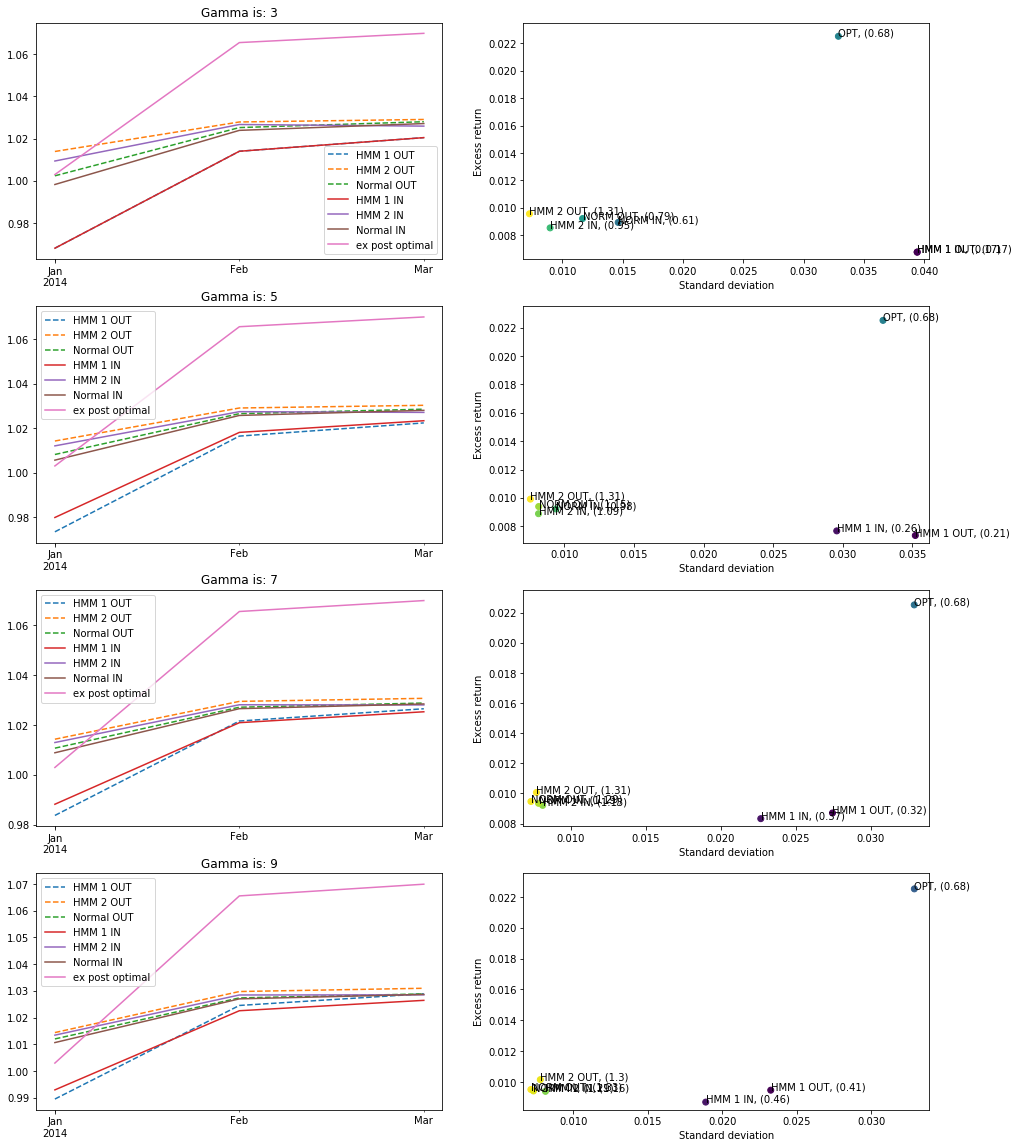

Investment horizon: 6
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.011549,0.011693,0.008279,0.009720,0.009725,0.009378,0.011693
Std. devs,0.025197,0.026335,0.007782,0.006201,0.009224,0.007427,0.026335
Sharpe Ratio,0.458349,0.444007,1.063813,1.567566,1.054236,1.262761,0.444007
Final Return,1.071800,1.072700,1.051000,1.060200,1.060200,1.060200,1.072700


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.010417,0.010960,0.008572,0.009635,0.009506,0.009295,0.011693
Std. devs,0.016373,0.020096,0.006061,0.005900,0.006215,0.005511,0.026335
Sharpe Ratio,0.636246,0.545350,1.414431,1.632978,1.529500,1.686728,0.444007
Final Return,1.064500,1.068100,1.052800,1.059400,1.058700,1.058700,1.072700


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.009922,0.010430,0.008697,0.009601,0.009413,0.009260,0.011693
Std. devs,0.012641,0.015762,0.005684,0.005916,0.005527,0.005271,0.026335
Sharpe Ratio,0.784872,0.661744,1.530091,1.622900,1.703071,1.756871,0.444007
Final Return,1.061400,1.064600,1.053600,1.059300,1.058100,1.058100,1.072700


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.009700,0.010147,0.008790,0.009581,0.009363,0.009240,0.011693
Std. devs,0.010217,0.013296,0.005590,0.005961,0.005397,0.005331,0.026335
Sharpe Ratio,0.949378,0.763134,1.572611,1.607163,1.734821,1.733122,0.444007
Final Return,1.060000,1.062800,1.054200,1.059200,1.057900,1.057900,1.072700


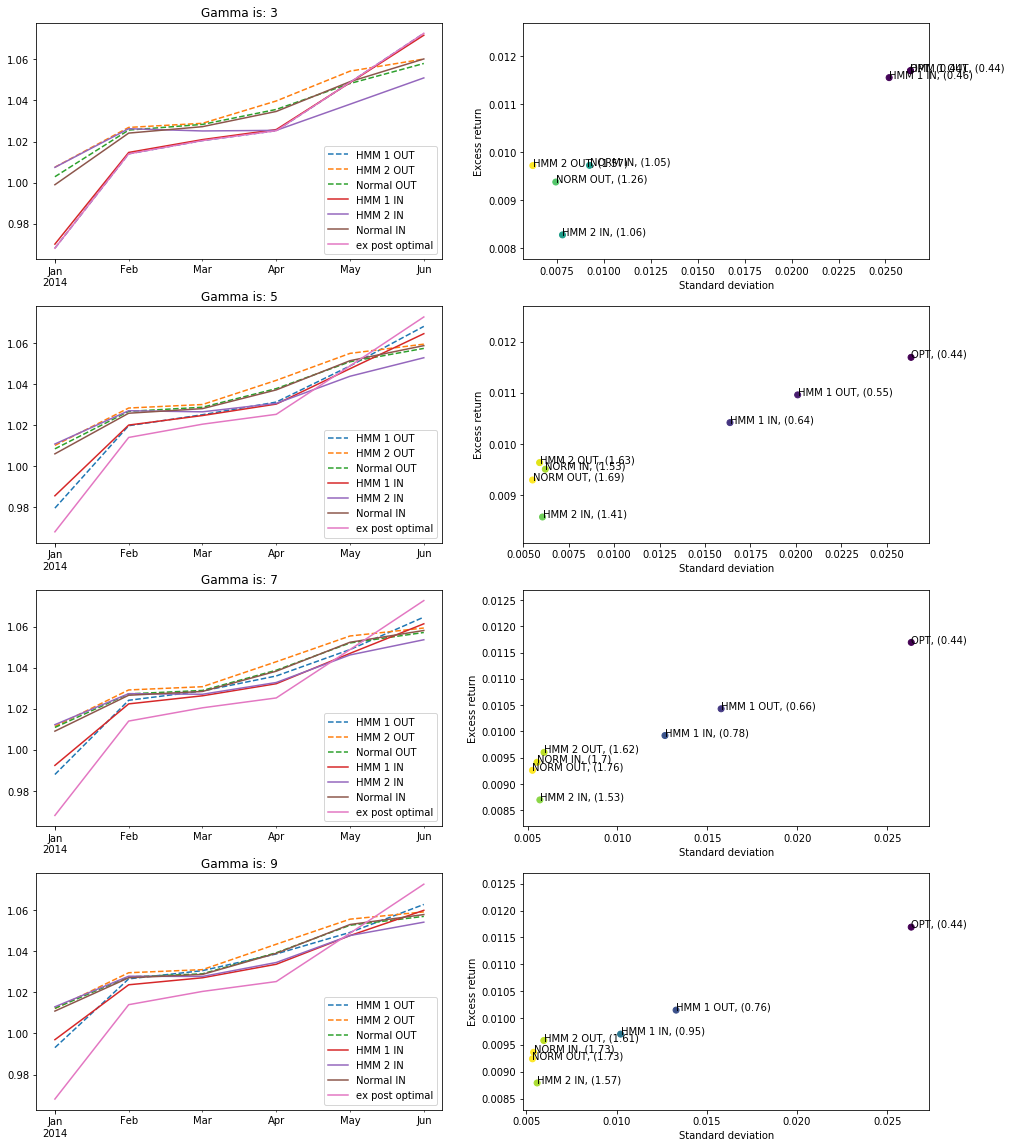

Investment horizon: 9
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.007629,0.008517,0.003235,0.006233,0.005687,0.004921,0.008517
Std. devs,0.023817,0.027049,0.016483,0.013186,0.014455,0.013479,0.027049
Sharpe Ratio,0.320320,0.314889,0.196251,0.472689,0.393402,0.365075,0.314889
Final Return,1.071200,1.079700,1.030500,1.058000,1.052700,1.052700,1.079700


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005998,0.006090,0.004142,0.005761,0.005743,0.005287,0.008517
Std. devs,0.018360,0.021459,0.013845,0.012192,0.012048,0.011663,0.027049
Sharpe Ratio,0.326699,0.283815,0.299197,0.472515,0.476626,0.453266,0.314889
Final Return,1.055700,1.057000,1.038700,1.053600,1.053100,1.053100,1.079700


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005696,0.004971,0.004531,0.005559,0.005770,0.005443,0.008517
Std. devs,0.015578,0.018862,0.012852,0.011910,0.011284,0.011086,0.027049
Sharpe Ratio,0.365632,0.263530,0.352527,0.466737,0.511369,0.491025,0.314889
Final Return,1.052800,1.046600,1.042200,1.051700,1.053400,1.053400,1.079700


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005673,0.004811,0.004746,0.005447,0.005784,0.005529,0.008517
Std. devs,0.013947,0.016789,0.012346,0.011793,0.010944,0.010826,0.027049
Sharpe Ratio,0.406762,0.286556,0.384442,0.461930,0.528534,0.510706,0.314889
Final Return,1.052500,1.044900,1.044200,1.050700,1.053500,1.053500,1.079700


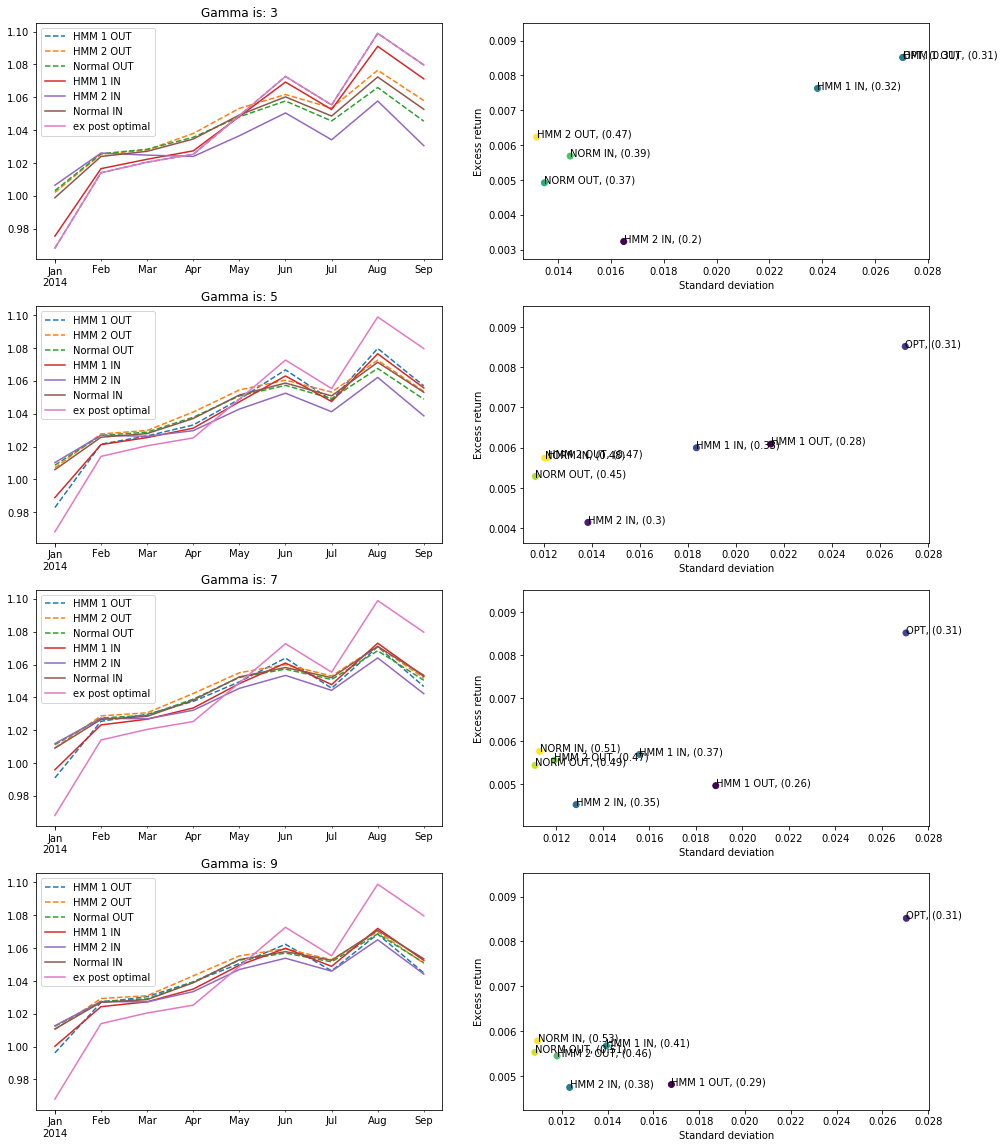

Investment horizon: 10
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.008871,0.010080,0.005257,0.006980,0.006585,0.005812,0.010080
Std. devs,0.022384,0.025976,0.017186,0.013233,0.013951,0.012957,0.025976
Sharpe Ratio,0.396293,0.388046,0.305867,0.527460,0.471963,0.448535,0.388046
Final Return,1.093000,1.106100,1.054200,1.072800,1.068200,1.068200,1.106100


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.007049,0.007162,0.005648,0.006366,0.006462,0.006004,0.010080
Std. devs,0.017432,0.020459,0.014110,0.011948,0.011603,0.011195,0.025976
Sharpe Ratio,0.404404,0.350087,0.400261,0.532826,0.556929,0.536312,0.388046
Final Return,1.073400,1.075300,1.058300,1.066400,1.066900,1.066900,1.106100


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.006716,0.006009,0.005815,0.006103,0.006413,0.006089,0.010080
Std. devs,0.014695,0.017782,0.012928,0.011550,0.010842,0.010626,0.025976
Sharpe Ratio,0.457045,0.337907,0.449802,0.528390,0.591485,0.573007,0.388046
Final Return,1.069900,1.063100,1.060000,1.063500,1.066400,1.066400,1.106100


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.006588,0.005715,0.005908,0.005957,0.006386,0.006135,0.010080
Std. devs,0.013215,0.015861,0.012322,0.011375,0.010500,0.010367,0.025976
Sharpe Ratio,0.498484,0.360330,0.479452,0.523710,0.608148,0.591778,0.388046
Final Return,1.068300,1.059900,1.061000,1.062000,1.066000,1.066000,1.106100


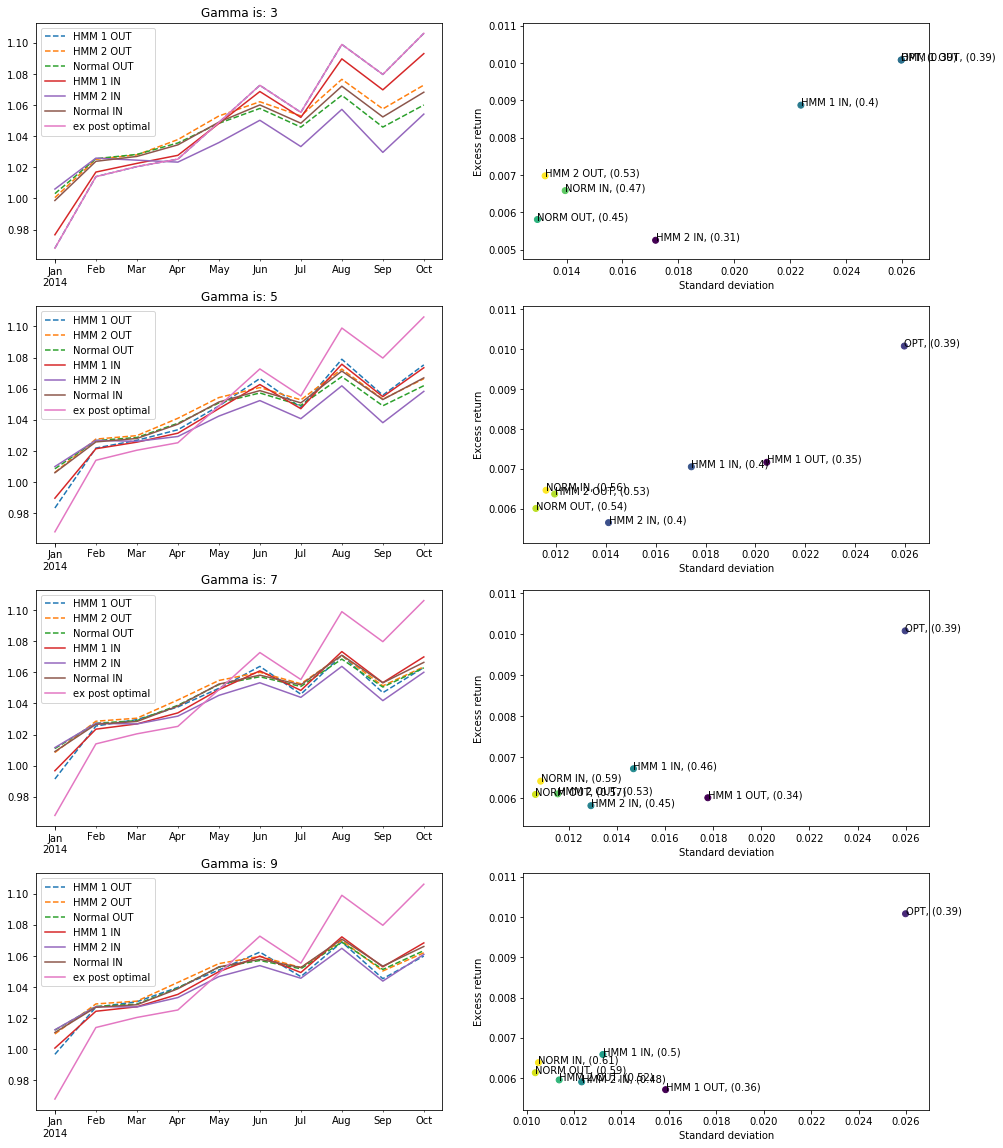

Investment horizon: 12
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.008012,0.010215,0.005435,0.006262,0.005340,0.004016,0.010358
Std. devs,0.020005,0.023989,0.016124,0.013382,0.013268,0.012558,0.024261
Sharpe Ratio,0.400484,0.425821,0.337056,0.467927,0.402485,0.319841,0.426966
Final Return,1.102000,1.130500,1.067500,1.080000,1.067100,1.067100,1.132400


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005620,0.005487,0.005619,0.005408,0.005433,0.004663,0.010358
Std. devs,0.015824,0.018993,0.013059,0.011805,0.010988,0.010725,0.024261
Sharpe Ratio,0.355176,0.288909,0.430329,0.458134,0.494452,0.434774,0.426966
Final Return,1.070900,1.071700,1.069800,1.069400,1.068100,1.068100,1.132400


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005534,0.004302,0.005698,0.005045,0.005476,0.004940,0.010358
Std. devs,0.013365,0.016547,0.011896,0.011304,0.010228,0.010101,0.024261
Sharpe Ratio,0.414088,0.259990,0.479014,0.446335,0.535420,0.489036,0.426966
Final Return,1.069600,1.056800,1.070800,1.064900,1.068400,1.068400,1.132400


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005496,0.004027,0.005742,0.004846,0.005504,0.005093,0.010358
Std. devs,0.012121,0.014946,0.011303,0.011076,0.009880,0.009809,0.024261
Sharpe Ratio,0.453446,0.269434,0.507996,0.437505,0.557041,0.519275,0.426966
Final Return,1.069000,1.053200,1.071400,1.062300,1.068800,1.068800,1.132400


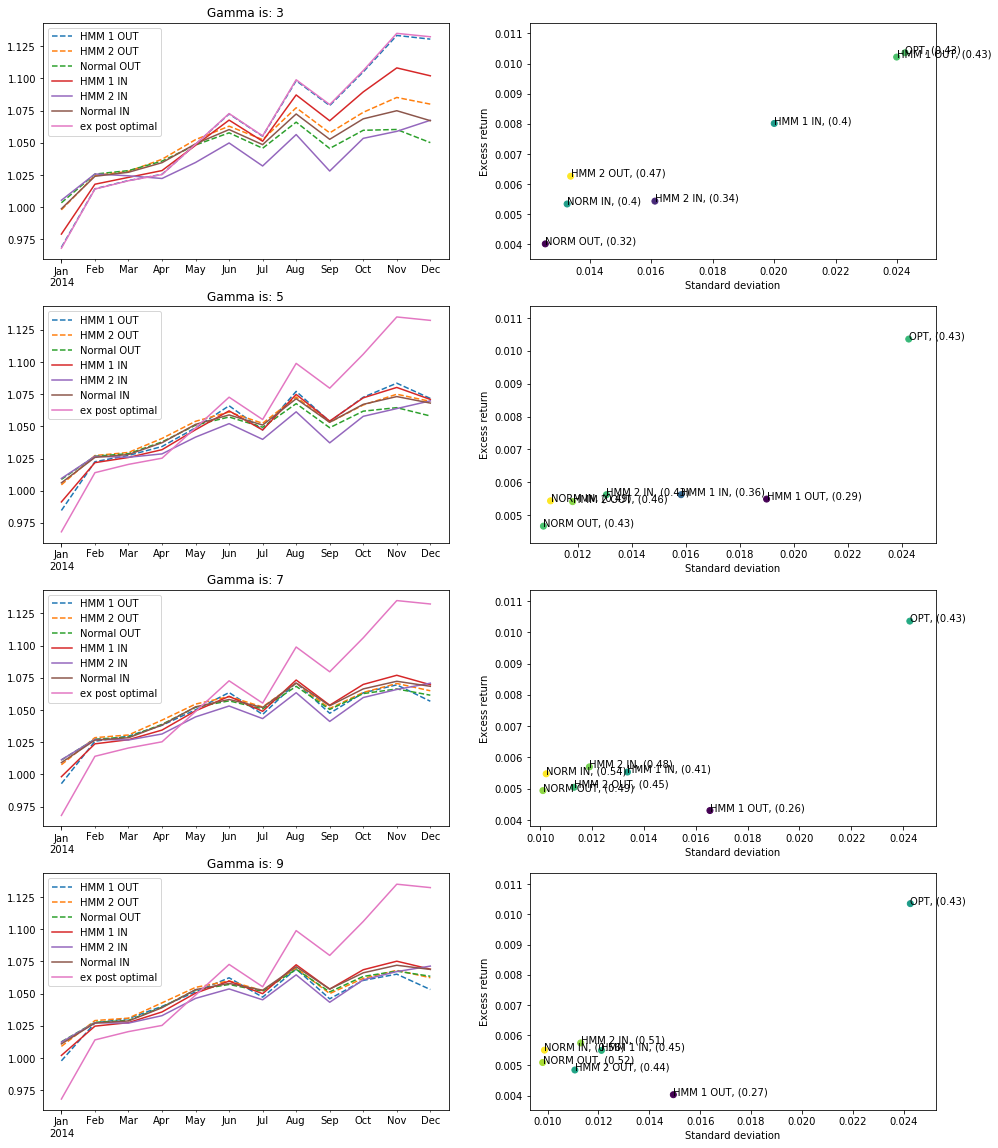

Investment horizon: 24
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.002839,0.004204,0.001832,0.002057,0.001773,0.000860,0.005553
Std. devs,0.023692,0.028686,0.016618,0.020618,0.016664,0.015096,0.031672
Sharpe Ratio,0.119847,0.146560,0.110237,0.099743,0.106401,0.056947,0.175331
Final Return,1.073700,1.110700,1.045500,1.060100,1.045900,1.045900,1.142700


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.002207,0.000854,0.002130,0.001419,0.001983,0.001466,0.005553
Std. devs,0.017297,0.022032,0.013281,0.015024,0.012649,0.011941,0.031672
Sharpe Ratio,0.127581,0.038763,0.160347,0.094464,0.156783,0.122756,0.175331
Final Return,1.056900,1.033300,1.052900,1.044900,1.050500,1.050500,1.142700


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.002213,0.000585,0.002232,0.001153,0.002076,0.001726,0.005553
Std. devs,0.014323,0.017572,0.012174,0.013025,0.011436,0.011057,0.031672
Sharpe Ratio,0.154492,0.033270,0.183346,0.088516,0.181570,0.156086,0.175331
Final Return,1.056600,1.026600,1.055400,1.038600,1.052500,1.052500,1.142700


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.002226,0.000447,0.002264,0.001012,0.002127,0.001869,0.005553
Std. devs,0.012879,0.015271,0.011653,0.012097,0.010955,0.010730,0.031672
Sharpe Ratio,0.172828,0.029284,0.194266,0.083663,0.194183,0.174157,0.175331
Final Return,1.056600,1.023100,1.056300,1.035100,1.053400,1.053400,1.142700


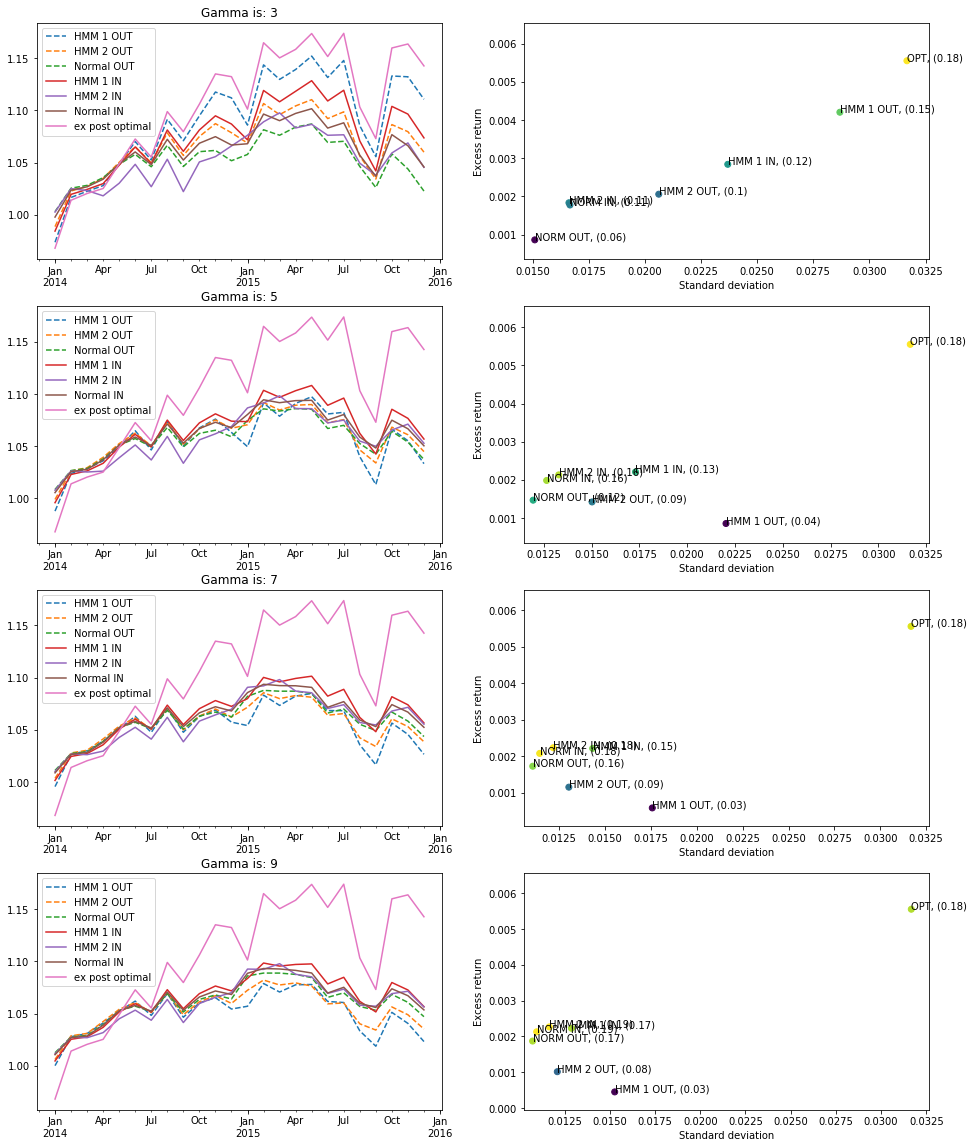

Investment horizon: 36
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005363,0.005855,0.004191,0.004672,0.004537,0.004154,0.006802
Std. devs,0.022758,0.027345,0.018406,0.022715,0.017124,0.016139,0.031010
Sharpe Ratio,0.235640,0.214113,0.227716,0.205687,0.264964,0.257393,0.219359
Final Return,1.217500,1.242900,1.166300,1.196300,1.181700,1.181700,1.280300


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.004637,0.004013,0.003924,0.003687,0.004087,0.003865,0.006802
Std. devs,0.016688,0.020903,0.014361,0.016565,0.013508,0.013136,0.031010
Sharpe Ratio,0.277870,0.191968,0.273259,0.222575,0.302584,0.294232,0.219359
Final Return,1.186100,1.171200,1.154900,1.155900,1.162200,1.162200,1.280300


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.004317,0.003444,0.003806,0.003264,0.003894,0.003742,0.006802
Std. devs,0.014370,0.017143,0.013078,0.014378,0.012453,0.012289,0.031010
Sharpe Ratio,0.300387,0.200909,0.291058,0.227034,0.312688,0.304470,0.219359
Final Return,1.172200,1.147500,1.149900,1.138500,1.153900,1.153900,1.280300


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.004125,0.003124,0.003738,0.003030,0.003791,0.003673,0.006802
Std. devs,0.013312,0.015281,0.012523,0.013371,0.012051,0.011970,0.031010
Sharpe Ratio,0.309890,0.204416,0.298477,0.226638,0.314550,0.306876,0.219359
Final Return,1.164000,1.134100,1.146900,1.128800,1.149400,1.149400,1.280300


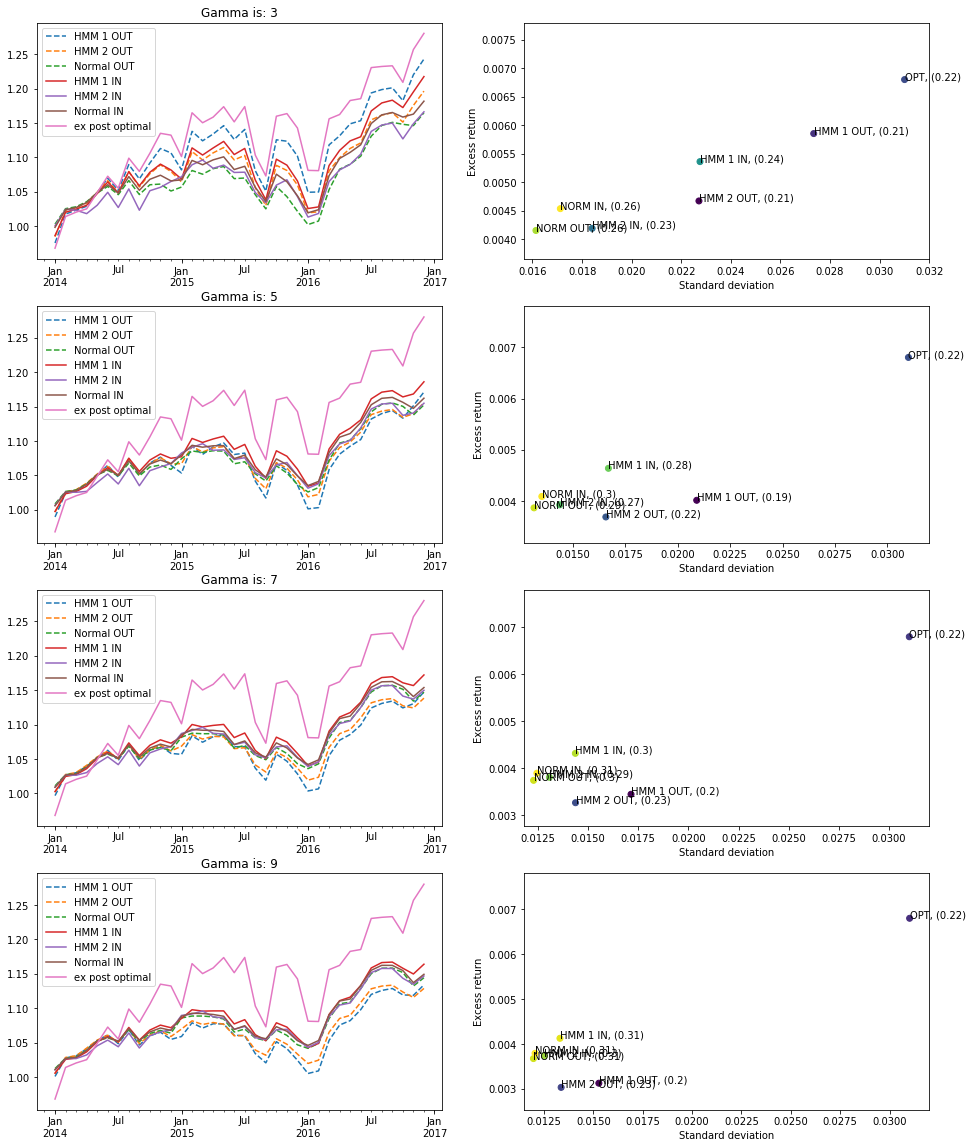

Investment horizon: 48
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.006649,0.007703,0.005222,0.006500,0.005418,0.004835,0.009024
Std. devs,0.019727,0.024006,0.016372,0.021181,0.015111,0.014273,0.027558
Sharpe Ratio,0.337049,0.320865,0.318981,0.306886,0.358537,0.338786,0.327476
Final Return,1.399500,1.475800,1.303700,1.403200,1.318200,1.318200,1.557800


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005529,0.005442,0.004675,0.004986,0.004725,0.004393,0.009024
Std. devs,0.014386,0.018065,0.012659,0.015246,0.011944,0.011631,0.027558
Sharpe Ratio,0.384337,0.301261,0.369330,0.327005,0.395581,0.377730,0.327476
Final Return,1.326000,1.338300,1.268700,1.307500,1.273000,1.273000,1.557800


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.005028,0.004622,0.004435,0.004334,0.004433,0.004205,0.009024
Std. devs,0.012487,0.014894,0.011488,0.013092,0.011036,0.010889,0.027558
Sharpe Ratio,0.402649,0.310352,0.386025,0.331010,0.401702,0.386198,0.327476
Final Return,1.293100,1.286200,1.253200,1.266200,1.254100,1.254100,1.557800


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.004744,0.004168,0.004297,0.003976,0.004272,0.004101,0.009024
Std. devs,0.011617,0.013335,0.010992,0.012086,0.010687,0.010610,0.027558
Sharpe Ratio,0.408349,0.312575,0.390933,0.328931,0.399797,0.386511,0.327476
Final Return,1.274400,1.257300,1.244500,1.243300,1.243600,1.243600,1.557800


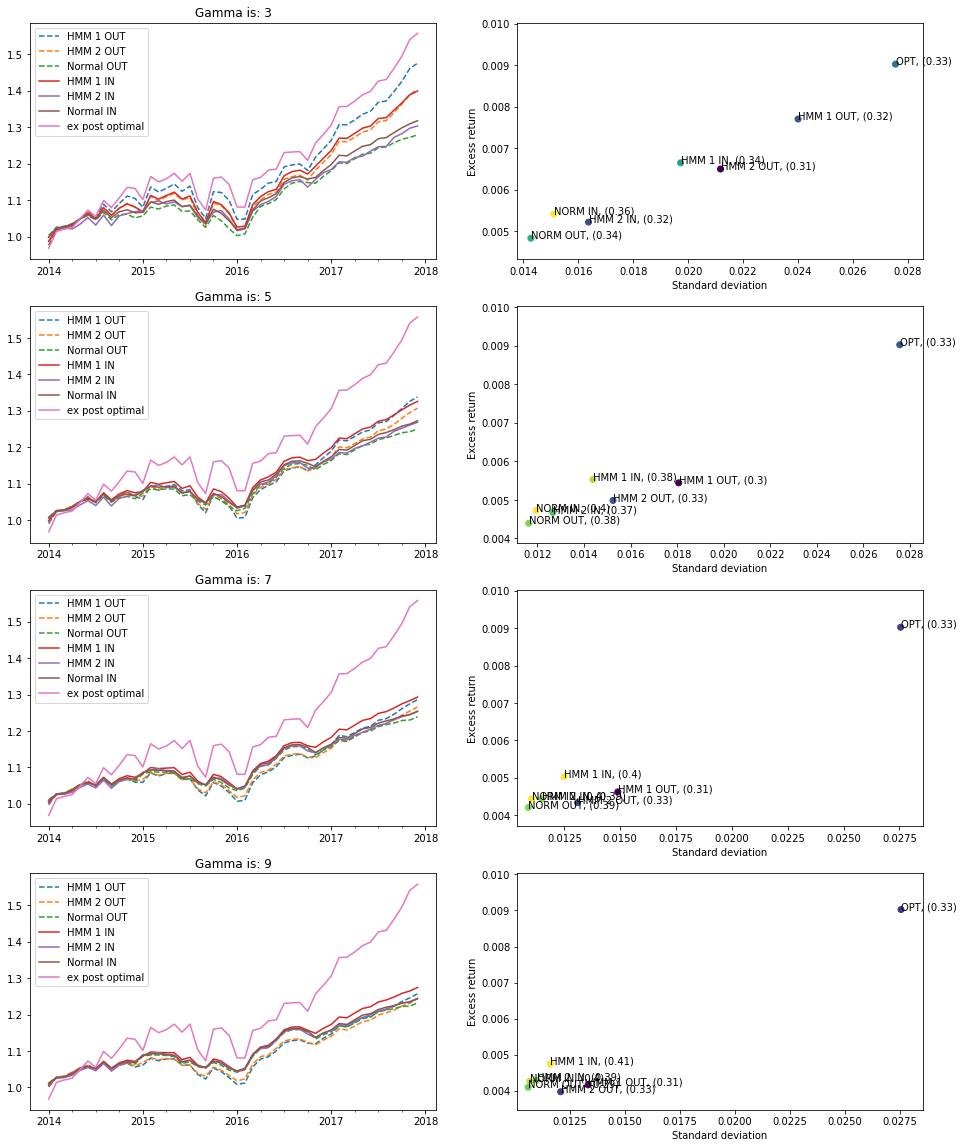

Investment horizon: 60
gamma=3


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.004351,0.004995,0.003208,0.004208,0.003542,0.003116,0.006103
Std. devs,0.021285,0.027206,0.018245,0.024394,0.016010,0.014382,0.031986
Sharpe Ratio,0.204427,0.183597,0.175825,0.172496,0.221229,0.216663,0.190809
Final Return,1.342400,1.403200,1.251300,1.347900,1.278000,1.278000,1.483200


gamma=5


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.003534,0.003294,0.002854,0.003023,0.003025,0.002777,0.006103
Std. devs,0.015300,0.019752,0.013766,0.017113,0.012353,0.011609,0.031986
Sharpe Ratio,0.230967,0.166744,0.207322,0.176651,0.244885,0.239183,0.190809
Final Return,1.277900,1.281400,1.223700,1.259100,1.237700,1.237700,1.483200


gamma=7


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.003169,0.002688,0.002694,0.002520,0.002807,0.002631,0.006103
Std. devs,0.013111,0.016015,0.012265,0.014285,0.011254,0.010841,0.031986
Sharpe Ratio,0.241710,0.167833,0.219644,0.176395,0.249382,0.242718,0.190809
Final Return,1.249100,1.235500,1.211400,1.221100,1.220500,1.220500,1.483200


gamma=9


,HMM 1 IN,HMM 1 OUT,HMM 2 IN,HMM 2 OUT,NORM IN,NORM OUT,OPT
Returns,0.002961,0.002359,0.002601,0.002245,0.002687,0.002550,0.006103
Std. devs,0.012090,0.014119,0.011592,0.012911,0.010819,0.010561,0.031986
Sharpe Ratio,0.244920,0.167064,0.224391,0.173896,0.248340,0.241493,0.190809
Final Return,1.232700,1.210500,1.204200,1.200300,1.211100,1.211100,1.483200


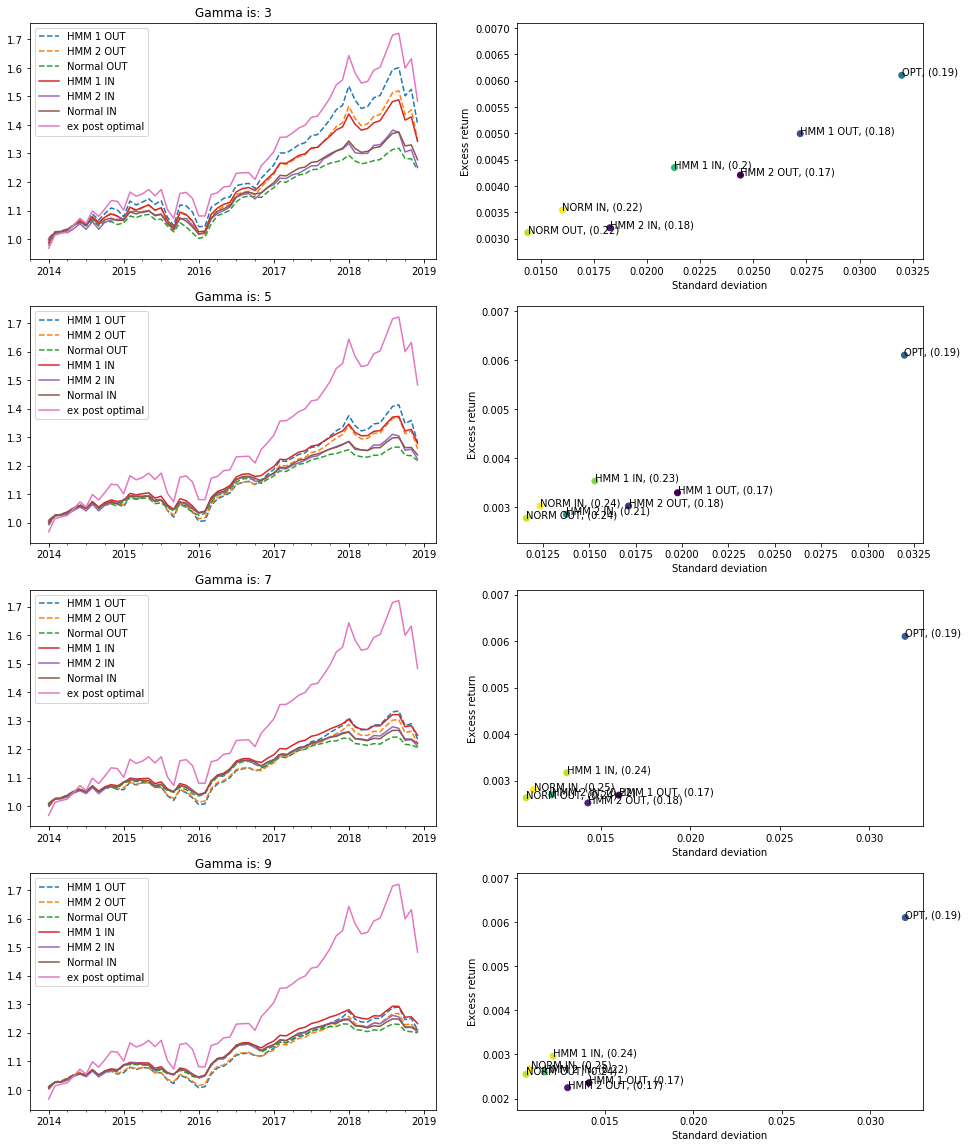

In [395]:
for j, k in enumerate(epw_keys):
    print 'Investment horizon: {}'.format(k)

    # Weights, .iloc[j,:] has j be the maturity by index -> [3,6,9,10,12,etc.]
    hmm_1_out = [np.array(hmm_ws_out[1][g].iloc[j,:]) for g in gamma]
    hmm_2_out = [np.array(hmm_ws_out[2][g].iloc[j,:]) for g in gamma]
    norm_out  = [np.array(norm_ws_out[g].iloc[j,:]) for g in gamma]
    
    hmm_1_in = [np.array(hmm_ws_in[1][g].iloc[j,:]) for g in gamma]
    hmm_2_in = [np.array(hmm_ws_in[2][g].iloc[j,:]) for g in gamma]
    norm_in  = [np.array(norm_ws_in[g].iloc[j,:]) for g in gamma]

    fig, axes = plt.subplots(4,2, figsize=(16,20))        
    for g in range(len(axes.flat)/2):

        # Axes
        ax1 = axes.flat[2*g]
        ax2 = axes.flat[2*g+1]
        
        # g is index of the gamma [3,5,7,9]
        hmm_wealth_1_out = hmm_1_out[g]*CR.iloc[:k, :]
        hmm_wealth_2_out = hmm_2_out[g]*CR.iloc[:k, :]
        norm_wealth_out = norm_out[g]*CR.iloc[:k, :]
        hmm_wealth_1_in = hmm_1_in[g]*CR.iloc[:k, :]
        hmm_wealth_2_in = hmm_2_in[g]*CR.iloc[:k, :]
        norm_wealth_in = norm_in[g]*CR.iloc[:k, :]
        opt_wealth = opt_weights[k][g]*CR.iloc[:k,:]

        # Actual plotting (left panels, g*2 = 0, 2, 4, 6)
        hmm_wealth_1_out.sum(axis=1).plot(ax=ax1, label='HMM 1 OUT', linestyle='dashed')
        hmm_wealth_2_out.sum(axis=1).plot(ax=ax1, label='HMM 2 OUT', linestyle='dashed')
        norm_wealth_out.sum(axis=1).plot(ax=ax1, label='Normal OUT', linestyle='dashed')
        hmm_wealth_1_in.sum(axis=1).plot(ax=ax1, label='HMM 1 IN')
        hmm_wealth_2_in.sum(axis=1).plot(ax=ax1, label='HMM 2 IN')
        norm_wealth_in.sum(axis=1).plot(ax=ax1, label='Normal IN')
        opt_wealth.sum(axis=1).plot(ax=ax1, label='ex post optimal')
        
        ax1.set_title('Gamma is: {}'.format(gamma[g]))
        ax1.set_xlabel('')
        ax1.legend()
        
        # Sharpes
        er14 = excess_returns_14.iloc[:k,:]
        mu = er14.mean()
        std = er14.std()
        cov = er14.cov()

        w_hmm_1_out = hmm_1_out[g][:5]
        hmm_1_r_out = w_hmm_1_out.dot(mu)
        hmm_1_s_out = np.sqrt(w_hmm_1_out.dot(cov.dot(w_hmm_1_out.T)))
        hmm_1_sr_out = hmm_1_r_out / hmm_1_s_out

        w_hmm_2_out = hmm_2_out[g][:5]
        hmm_2_r_out = w_hmm_2_out.dot(mu)
        hmm_2_s_out = np.sqrt(w_hmm_2_out.dot(cov.dot(w_hmm_2_out.T)))
        hmm_2_sr_out = hmm_2_r_out / hmm_2_s_out

        w_norm_out = norm_out[g][:5]
        norm_r_out = w_norm_out.dot(mu)
        norm_s_out = np.sqrt(w_norm_out.dot(cov.dot(w_norm_out.T)))
        norm_sr_out = norm_r_out / norm_s_out

        w_hmm_1_in = hmm_1_in[g][:5]
        hmm_1_r_in = w_hmm_1_in.dot(mu)
        hmm_1_s_in = np.sqrt(w_hmm_1_in.dot(cov.dot(w_hmm_1_in.T)))
        hmm_1_sr_in = hmm_1_r_in / hmm_1_s_in

        w_hmm_2_in = hmm_2_in[g][:5]
        hmm_2_r_in = w_hmm_2_in.dot(mu)
        hmm_2_s_in = np.sqrt(w_hmm_2_in.dot(cov.dot(w_hmm_2_in.T)))
        hmm_2_sr_in = hmm_2_r_in / hmm_2_s_in

        w_norm_in = norm_in[g][:5]
        norm_r_in = w_norm_in.dot(mu)
        norm_s_in = np.sqrt(w_norm_in.dot(cov.dot(w_norm_in.T)))
        norm_sr_in = norm_r_in / norm_s_in

        w_opt = opt_weights[k][g][:5]
        opt_r = w_opt.dot(mu)
        opt_s = np.sqrt(w_opt.dot(cov.dot(w_opt.T)))
        opt_sr = opt_r / opt_s

        rets = (hmm_1_r_out, hmm_2_r_out, norm_r_out, hmm_1_r_in, hmm_2_r_in, norm_r_in, opt_r)
        stds = (hmm_1_s_out, hmm_2_s_out, norm_s_out, hmm_1_s_in, hmm_2_s_in, norm_s_in, opt_s)
        srs = (hmm_1_sr_out, hmm_2_sr_out, norm_sr_out, hmm_1_sr_in, hmm_2_sr_in, norm_sr_in, opt_sr)
        
        values = zip(np.round(srs, 2), stds, rets)
        annot = dict(zip(txt, values))
        
        ax2.scatter(stds, rets, c=srs)
        ax2.set_xlabel('Standard deviation')
        ax2.set_ylabel('Excess return')
        for (key, a) in annot.items():
            ax2.annotate('{}, ({})'.format(key, a[0]), (a[1], a[2]))
        ax2.set_xlim(xmin=min(stds)-0.0005, xmax=max(stds) + 0.001)
        ax2.set_ylim(ymin=min(rets)-0.0005, ymax=max(rets) + 0.001)
        
        # Return prints
        print 'gamma={}'.format(gamma[g])
        
        fr = (
            np.round(hmm_wealth_1_out.iloc[k-1].sum(), 4),
            np.round(hmm_wealth_2_out.iloc[k-1].sum(), 4),
            np.round(norm_wealth_in.iloc[k-1].sum(), 4),
            np.round(hmm_wealth_1_in.iloc[k-1].sum(), 4),
            np.round(hmm_wealth_2_in.iloc[k-1].sum(), 4),
            np.round(norm_wealth_in.iloc[k-1].sum(), 4),
            np.round(opt_wealth.iloc[k-1].sum(), 4)
        )
        
        data = dict(zip(txt, zip(rets, stds, srs, fr)))
        display(pd.DataFrame(data, index=['Returns','Std. devs','Sharpe Ratio','Final Return']))
    plt.show()

### Conclusions

1. It seems that, the more risk averse we are, the more a regular normal model has merit.
2. For long horizons the HMM models perform best (after the optimal allocation)
3. The normal model is rarely outperformed on Sharpe Ratio, and then only by the optimal portfolio
4. If we are risk takers, the HMM 1 model has its merits
5. For very short horizons, the HMM 1 and optimal portfolio coincide
6. Sharpe Ratios tend to improve as risk aversion increases (increasing $\gamma$); there are many exceptions nevertheless

In conclusion, we recommend the HMM models if we are either investing at long horizons or investing aggressively. We should perform the same test on other out-of-sample periods to conclusively say these results aren't random.